# Painter by Numbers

In [1]:
#@title

! pip -qq install -U tensorflow-addons tensorflow_datasets scikit-learn

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

import tensorflow as tf

for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [2]:
if IS_COLAB:
  base_dir = '/content/drive/MyDrive'
  data_dir = '/root/tensorflow_datasets/pbn'
else:
  base_dir = '/home/ldavid/Workspace'
  data_dir = f'{base_dir}/datasets/painter-by-numbers'

data_records = f'{data_dir}/train.tfrecords'


class Config:
  class data:
    path = f'{base_dir}/datasets/painter-by-numbers/train.tfrecords'
    info = f'{base_dir}/datasets/painter-by-numbers/meta/train_info.csv'

    size = (299, 299)
    shape = (*size, 3)
    batch_size = 64
    batch_size_inference = 64
    patches = 20
    shuffle_buffer_size = 24 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 2142
    shuffle = True

    valid_size = 0.3
  
  class aug:
    brightness_delta =  .2
    saturation_lower =  .5
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0

  class model:
    dropout = 0.2
    backbone = tf.keras.applications.InceptionV3
    feature_layers = ['activation_4', 'mixed2', 'mixed7', 'mixed10']
    build_options = {
      'predictions': {
        'kernel_regularizer': tf.keras.regularizers.L2(0.01),
        # 'bias_regularizer': tf.keras.regularizers.L2(0.01),
        # 'activity_regularizer': tf.keras.regularizers.L2(0.01),
      }
    }

  class training:
    epochs = 80

    logs = f'{base_dir}/logs/painter-by-numbers/i3'
    weights = f'{base_dir}/models/painter-by-numbers/i3.h5'

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    callbacks = [
      tf.keras.callbacks.TerminateOnNaN(),
      tf.keras.callbacks.EarlyStopping(
          patience=20,
          verbose=1),
      tf.keras.callbacks.TensorBoard(
          log_dir=logs,
          histogram_freq=10,
          write_graph=True),
      tf.keras.callbacks.ModelCheckpoint(
          weights,
          save_weights_only=True,
          save_best_only=True,
          verbose=1),
    ]
  
  class fine_tuning:
    epochs = 120
    lr = 0.0001

    unfreeze_layers = 0.6  # 60%
    frozen_bn = True

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    logs = f'{base_dir}/logs/painter-by-numbers/i3-ft/'
    weights = f'{base_dir}/models/painter-by-numbers/i3-ft.h5'

    callbacks = [
      tf.keras.callbacks.TerminateOnNaN(),
      tf.keras.callbacks.EarlyStopping(
          patience=20,
          verbose=1),
      tf.keras.callbacks.TensorBoard(
          log_dir=logs,
          histogram_freq=10,
          write_graph=True),
      tf.keras.callbacks.ModelCheckpoint(
          weights,
          save_weights_only=True,
          save_best_only=True,
          verbose=1),
    ]

  class experiment:
    seed = 753
    override = False

In [3]:
preprocess = tf.keras.applications.inception_v3.preprocess_input
deprocess = lambda x: (x + 1) * 127.5
to_image = lambda x: tf.cast(tf.clip_by_value(deprocess(x), 0, 255), tf.uint8)

## Setup

In [4]:
import os
import shutil
from math import ceil

from typing import List, Optional

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [5]:
for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [6]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [7]:
def opt_or_default(options):
  def _get_options(param):
    return options.get(param, {})
  
  return _get_options


def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=None,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      if not rows:
        rows = 2 if len(image) > 1 else 1

      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [8]:
def unfreeze_top_layers(
    model: tf.keras.Model,
    layers: float,
    freeze_bn: bool
):
  if not layers:
    model.trainable = False
    return

  model.trainable = True

  frozen_layer_ix = int((1-layers) * len(model.layers))
  for ix, l in enumerate(model.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not freeze_bn))
  
  print(f'Unfreezing {layers:.0%} layers. Bottom-most is the {frozen_layer_ix}-nth layer ({model.layers[frozen_layer_ix].name}).')

## Datasets

In [9]:
if not os.path.exists(data_records):
  ! mkdir -p $data_dir
  ! gdown --id 1Z9yU-elQ9xetB8TwY534JxaowvdXWAnO -O $data_records

In [10]:
from sklearn.preprocessing import LabelEncoder

class PainterByNumbers:
    train_info = pd.read_csv(Config.data.info)

    num_train_samples = 79433
    num_test_samples  = np.nan

    GROUPS = ('artist', 'style', 'genre')
    
    encoders = {
      'artist_hash': LabelEncoder().fit(['003cb9bdfadc23495b51a630f8af2570', '0052cc81f35d53736ab860be16fc07f4', '00a5e68f22bff52b51c8a76754afa8a8', '00f78fa862830cc1ba569285da3232ed', '00fc66616732eee998b037e68ab7fccf', '012bd50d44685a367716570e252c7556', '01817fee724e0c55ff3013b9d5da3e1c', '01c28714c9274000f7fa5856a747ea8b', '01d069f37d7004e7b11de0d6abb8f3d7', '024cbb4297ab2babbf5749b3ff7468b1', '0262857af5392345a4d9f852b55369e2', '02957a471533ff4921fa01fcdec60553', '02b5b7db02d3fa2bf86aa034f8799720', '02b866899dc71a00364337e830d075d7', '02c5e2cd3cd6c64f358f6e26892d247f', '02d70388e12718a1f0117c5a2a513255', '035c74d2bb22742f9ad6a01600036c56', '03ac41c33b5a777713a5dd0d07d01df8', '03eb72f3b50cabc136056918808ba5cb', '03f28fbdb3d6543f4b0d9307d0b7da00', '040827f8fb458d1cea7d3e0b9e33132f', '041b8f718d4ea537b14762cccc012d87', '04687b57416119aa3341483713e51de2', '0507704baf3cb8afca454f11276780a3', '0543dab6ae5c1a984446396bf37ed065', '0549f194ce656a3a2f59da5ac7ba2235', '059d590e174c545474f0fedcc126ce4c', '05a3d2b6995d83ffd6fde79e29139238', '05a5bf666fa1d82ab1c4ce0891286adb', '05b68aa79caec9b1b08adcc71db67816', '062244b785e58518f2f189329633c59e', '0641cf433776d46e89adfe142bd22379', '0682c5c8975d0d3514685b555b2f143d', '06894971c9eb44043a50eecdcb63ce56', '0699fb3041c52233a5ac295f96cc531a', '06efc56fcb7f00adfadd5eddee239fcd', '06f82951366bafca791e325cb6b214ac', '071365e38f1ab6565334bb8684ad8b93', '072592d6fa48c2ef2d5d248c0478e890', '073b2c35d9e00e88a88451ecd6c9d16f', '074e0101bc9582a768e1201058693538', '079566c5b40f28ab6e37d22f3e17d549', '079af364947be8a33dae3435712aa5f3', '07c533c28369f1e2b027f6a0c827d90e', '07cacd9eb814b3c07746816ff93d7eb8', '07dc09a362e1ac034010ff3948100d30', '07e1a430677c0057e9406f16b2c975ca', '07eb5eaa97f3e0de0b3d1773336fcabe', '08c4cc9a780f0612c5de0a6db16c02f6', '0907f8bb4c2d3ebb08b59f263f71596a', '090ae46a63a35e21a23bbd3f6179949d', '0925b0aeb81b5e69033ea61a09d15e11', '093d54c8398df0ab85b48e53faa54940', '09e1122dcc7247509bf3a7232268cab7', '09f10ed3f09cbd07aa596749c6277ea6', '0a44213d485e420c7a3cd652d7010b7b', '0a561c1ab44edb02c56f0ab9eae1b863', '0aa40001869bf1e86a1bdae741f79220', '0b0407ab1cddf41935944b0c79e6a6f4', '0b4f4983e55dbe5a88802329fc9ab828', '0b54db7f05e151ca4573da981bfa111c', '0b551b14f0c2b18ba795dc9db501dc4d', '0b8cc1cc180436962c4b593ee87f2163', '0ba3d2137d94f3fc2df6762ae5a27c13', '0bcb92c31517c8a35c0750257be5c5c9', '0bde8886304984b9818688afbb90e844', '0be7d2d98680435bcfcde984bdcf9b39', '0c26c67df9f976c9c179e379cf372949', '0c39086573b9afb45bfa645ded427c8b', '0c491bebb405572a8fca52e950a45c20', '0c4aebb696abe69e8b437abba61f6084', '0c7eaecdec27857c7a62125561cd32d0', '0cb735c435dad57f89347db93502c882', '0cde70ab5b820e18dc5b82405b1666ff', '0d08cb8d55bff60d0b6d47fe4ac06f42', '0d0a35494b33630a3242fe0c265c6e2a', '0d138ffcc570102982abc5b16d398107', '0d7b9ca487e6b4665f70ba1b77604fd2', '0d7e65a32297ad35333b34aa65274d8d', '0d7f1d0abadb2ac16cee65f03dcc4b85', '0d899a0eb3988f433ffc667b55bd430e', '0da1356c2cde09a219e0cc411e148452', '0dcfecf6e6a3ac3ec200de01e5f7f8f7', '0e594237beb312c7a2111e5e34242726', '0e7dcd50b9f822426707f94a45e8a865', '0eb191846ac88a74bb16b0a66a3117be', '0eb4b764437df0fa2b50efd963bd4f83', '0ece387d8d9b0016a027f2c9b0786723', '0ee36ab150c174ccbfbdc2c028ae7acb', '0eeac4ecff259dc515be795e1a76019a', '0eecbc7935da6d82624ced49125858c1', '0f05ba8fe45bc6e464a4a35a85d060d2', '0f556e6587c43aeabe062db8b17a760a', '0f62f2e018a609d5c86b6be720135cc7', '0f69bddfb509bab0de6a977795a2054b', '0f71842b436c4e5903c9584c4d2ef587', '0f80e5e4699fa73837d2f6b8f0aa74b5', '100b8df696f2b625407c9bc96f771738', '1033b8d5e48751160310866f129b7aae', '10384673568c58673bea9eb3c0cbebb6', '1058d8ff56d3ea71ef7f5c02a769fc8f', '105d9c73b49a9fe9232104646ea76020', '10bc951c2eb4a2f05fa773bdaace4e3b', '10be6a2b5f23ad60bbea05bb2b9fe392', '10fa8daca394c750f0112da41df65021', '113a9a08b3eb9a1d09487c7dae2f260c', '1140c7351c3f3eb1fd9d703fa15d92e1', '11a3a604361b93a2f3c2c34b5a82a668', '11a65e27c3585580b467611f3c462722', '11b135ede08cfc9833a834196db02f0d', '11dd6c23a452b7f044266368fe44e5aa', '11ea911b059c1d4b6c1c59f6cb67191a', '1218cd72eae00588536b91d095fe2bf3', '121fffad1eb6f7dff228b8a71b6aec72', '129349585c3d1f312535b6619fc36bf7', '12b0e7d955ca4efd56590fe4ccb88dff', '12b5ed543127a1a4b92ab9b548e903d5', '12dfb12ee87cde6a8dd88d10fb3075f4', '131f6c460383023d9ecd361d4e740902', '13215adefcbbfa25a01a7dbeffe6aee4', '1340e608b378090c58244e906ae138b7', '138b57708cd0838e2409cb18b19311b6', '139e4feb4346b2ef87afb7be838e8220', '13bfbf505674b6050a7e1d1b7687d228', '13fb1d497e1759ed5311c5222fb02685', '1419dccc553b12e6c8be580922985dde', '142921ad39fdb296b9c379cf42006ca1', '143da16251170dba1006dc7fe9c7871b', '1468ab18764365ded902fc726aec2c89', '147b0f64f4c2848bc0ad7bc1cdf74afe', '14ca2cd12133edb1537d0d0c8e557e40', '150ef565e5793bd8dd5bac4fdb23b894', '15195804309b239454f6dcc90b2f90da', '15655e4a7edb785645d9c9fe696e4a64', '15b0b53076339ba1f7904b45265ddd88', '15bd5100c248586f73b68cbbe4834ce5', '161364b5f7d16253286af542af2b8e98', '1630cb5bf45aacd7b253ab47a1597328', '16548363e96f1c64ca498fd00352df9a', '166f2b41057d24d97514a2cbbfdab0e3', '16a28d278fe1f08de74c39ffa774cdb1', '174b731536cc0d7b1903283cf87bd7a1', '1784ca34f1a06ba6eac22a83a5b0244d', '178f7766e498b9eb78f96422b0f96845', '17d7e6e3171d68e616897f0e09745ae9', '17db7fae1581897c9bbd696730845586', '17e732405ccfbe64d877ef68954d0131', '183ead1b4ef41afcb47cd4fcb9f5a1df', '18ef52d58ddb60c39c31f3b038c5bc96', '18f16730ca9e273f2a9064086f851365', '190b430ef19f47ad9da18f8c7b06523a', '1932ed03f66a00989a6193fd10b2da0b', '1950e9aa6ad878bc2a330880f77ae5a1', '1961d6dc3abf1c839b8b37b5993a2d25', '19aea5cea55a1fe4a3de39987b434a27', '19bf86183b442d420cd434daf8069769', '19cefbdc3612660557f546970f0302f5', '19e08b713138f86ffd2c42866f14cddd', '1a8d67dbb446bdc4298cc0be56932a38', '1aad726194868ad7760d7cb80673b697', '1ae80fd3af969741be58cae9964af887', '1b364d98237678788dceab6d21ca5d7f', '1b378307fee7afe5b48562761a3b5934', '1b472e873789aee4c2f61bfdd0681174', '1b75de7e18ba6fa547a7aed27b4fb355', '1bc5c079bf61b6ca1a7e16d9cebf4c85', '1c3585c12e0917cda33d523cf5f23b10', '1c4aafd8794c20a5ef34cefda3a84325', '1c51f1b94900279a51446182f270f2d7', '1c5407282a71e0e75098cb7bbfc30295', '1c5808517b3b9560b277eaae7adfabfc', '1c7fe46e9ea85fabf44eaa6daeb8a184', '1c8b3b3eccac6a1db53af62be90c4830', '1caf793576d1d6812d657976dd9cc96e', '1cba23922264c73ebd9da85d63045c7c', '1cdfd8192834e61b3543e3ce839950eb', '1cec93e2eb386945ea002f7b1b594a08', '1d15804e25b70276f3e0ddc66da4bbc9', '1d3da72424d2efdb9a44d7fe9b3d955f', '1d6d112c140cb6d1d763a7ca73f2eec0', '1de044bfdd9b1fac7c5d70efc1ac2604', '1dfc4d9fc9461efb99a4138c1966e1b4', '1e0aa40ee8d2974b22344dd8f1bc6c0e', '1e595d48fcdc7832cb923efc35aa8da4', '1e68eebfe4824339a7f1afefd81ffa3c', '1e7ffd6f66de716c62c8b9c89c21494f', '1e8267251976e6f3b771b00f32c5798b', '1ef451a39c6209ccfd746b165e077204', '1f020171f1660f14a8c822045b158a66', '1f4ea4aefd2cda9cc1fa39ba072ffec6', '1f5e33061c55cbdbabedbe0771b02e01', '1f7bf0455ebdfce199ef7a8444c7706b', '1f9ab405f6054bbb99446b9beb85ac9c', '1f9ad6b45d337ea18d7bd2b829800856', '1fa147a618221dd5c3347e22e0d21cc9', '207d95a590472b1e423e4adc6a567f64', '20981bb615ca19f736e2ab84c83a468e', '20997d2fc9ef66fccb7225846c1e1ae4', '20a67d55f6ae0285e7524242bf606512', '20ad4b8323d892d215b6b11c7476ef78', '20b7a2829e49e35a04642211271ed63d', '212176b716c26aea43e0fe1f15584f31', '216b7081d4b505f514fe00fcf0c4a5ec', '2196c96d3612334fa07aa43daa6ef322', '21c35f8cdf35a945ff7113c47378072f', '21f21671f0017453e10f2a6afe61a1b9', '222bd9c37588da9200ec4d46707632c2', '224470702136907d122b29f6916ac660', '2277ceef9e06b0a841062fdfa6de971d', '22a0b928cb37e7e6aa77110aa77a6791', '22a5e4780daa9b676b6984d34d63c175', '22d85263983f6014f350236cdb131bd7', '234c8d1df0b49b512791078cf00cf352', '238d10fec1d82ba6fcf670c50c8730f7', '23a39908a47139c0d2909d99247c0564', '23f8fa598ec48cac4c404a80ef1d43ae', '2421c77648e22dc313528d738fab1000', '24322e453b6957da6793a2c384b1f595', '243f2396b12f19be7abd30ada72433d7', '24469767ca1b3b1707c5806ba71eaba8', '246d953276d4fc29e6c2f4ea4616daa5', '24737e13e24bf959b89f88d35aae6f18', '247463dd5109151dedeabfd31016c75c', '247d7ac4c3823766890e6f61ec1d87ca', '24992a1ddca2a38675f62a88ff93f8a6', '24aa3b8d132a64607956435cbcb4abfd', '24ed88087b0ffeb763e89a197a5cde0d', '25621d7113c248c3062cb4bfa349b012', '2574d646c4252bdd87d253847eedfdf3', '25ae5f1122be2bd3460525c418b9d492', '25b752932874a46bf760fbb4ba3ae154', '25cf8fb4c82e9855d907b3a1c5dd00f6', '25d1ba595360201ed8ec8823cb0c15ed', '25e2bb274052f6ec15b8c981ae9f336b', '25fcb5eeab5068c6f0fab4c9d5a6fa2a', '2602b191b78d6ea4b42a28946eb82c38', '26755a62139244c958725e91e3c667ec', '26843672d445ff63f26de9d7f1a46607', '26f9b721302a00962439d50cc9b5faaf', '2758fcef28414c3065d93ff791211566', '2766e4c8b73e0cb18f793451e26ffafb', '27794b6a67ffd08ee18136c79bb593ed', '27c80514a59b9ead70bd2ec4cb165a9b', '289368a0d294ec4a0d531c270faf8de5', '28af2c0bffbfe423dc5b8b9b6aaf2415', '28fc41d6f8efc4e8b85a7e03e5d319fd', '294d0a61d897faf13708824d9a86bb04', '296186b92184ecb968798bc6d6029067', '2994dc2e6be69e64f1b6f5ae723fe61e', '29a5435bf13d80ce2e860e9bf8d52080', '29db1f42c929f11d01b0acb1dda2967f', '2a2f5222c870a3843794188fdfb9a85a', '2a3c2ac2d70f605f8d21aee98fe231f1', '2a45bacf1ca9500ee789d3be7c79d4b2', '2b304d8eacc1f21d0ad66b2f2f5520b0', '2b41d2845d08474c2e88e362f1312fe4', '2b8712e50aee6eda760ecc991ff54832', '2ba2949ecd56f46efa5333b006797cc4', '2ba365352b37c48e22d6b12415c44ecc', '2bacbbdcfae37d0fa719b0ef843107d3', '2c1805af81677619c237bcc6bf4a2897', '2c3565fbb40f040a5756ab50159bcaa1', '2c3ed36cea2be1c193103b5e88b66a16', '2c619a6f61c12b8295ded4d733e8d97e', '2ca19a6f1f33d97c1d8d5198e7127e2a', '2ca7e9a647c1c723349e37d3d60c7b7d', '2cd87bc71a43270dc7ce0917f6f6d980', '2cf708ebd3f8e408e1e54ef194614d03', '2d18519eacdb52f6406219633d25815c', '2d1d5059ec661daaa7b0e921e708c7b8', '2d25b6c56240608019375e50a9c6d605', '2d72f2000c42051e7c350a39bdce9bc1', '2de183deab2a0772fd2b478f56d7c3e1', '2def0275aadb44b398aa3972489bef7f', '2df967955e8a78fbdbcc6421a0492703', '2e068829a91053305098c99d53b754e5', '2e1c098c67bc11e0885c79ee8af0f61a', '2e31e2dc9bac8e4a0b718e4cfeb724ac', '2e62be02398f66f8fd74830e1473e4a3', '2e88816cf2cbf32d00cb8873f25290fd', '2ec05210b67f6af847e020d1fede26d4', '2f1ba47c4b9a2d8f5a25c7bd1bcd3bb4', '2f5a90d2491aeddfeff7230bf4119f08', '2f60fd6ace6df69a01b3a1106134971f', '2f68ecc70bbc7f82c679905e1ed3c467', '2fb04b8b8492dff1d019d1922fa33894', '2fcffbadf77e4311e228c45eeb7408c6', '2ffce49258565705f6d787d504675ece', '3007fcba96d9941a481321b6367721a1', '300c247c7a4d15b038983f91b1f837e2', '30134467c49a3350f74b4311506f8386', '30390422bb9f06f1b7a250a9ff955c25', '3070182db82f8b5d908168d99bed421e', '30808b4d00840f1352ca9b2ed47e0c64', '30923d83c0be8517133060583c9ae60b', '310cf91320c5fe1a6dea67ea3fa456a6', '311123bb51dd28d9af260456b5e54645', '315e56b8704c891d56078e7dafb6a39e', '31824744c8ae0c7953098fdab60c7ebf', '31ae9bb585de7007e51b578f800ec5e9', '31dbc08b8d0a3196c5484c0c068b2bcc', '3206630d0307a51332598b034e7075d6', '3208cb87e3bedfcbdbdbd8b9c66b6a9b', '3244a5fbd1c5280f8f0fecef93b799d8', '3267c7910e67fdca840d4c38f72e4b70', '326dd65862d92527a43392ec61e2187c', '32797cdac32fc278d11ea51c8f907635', '3310a92ab10b1057375c0e36538861fa', '3354b8820b6c7eaa725cececfeb85a6e', '33fbba0a786451ed0ed45b0467349cfe', '342d7068656b00878b23e1031a3ddf50', '345dc3f45c95d3fe04f8c192cc8ed8d2', '346af325ae2c4d1f39e7a9d47d852518', '347c19bed0bc29e071c9677e1c2cda5b', '348099560eb97dc0419df9a8bb8f1193', '349493c7240669fdf037e3d2c2fcd9a9', '34a15cafb88ef8ec6354c305a83c30df', '34af3fde07e283bb8c99f8de85e5f94d', '3524ecd495d905ffbe4f424717d747a1', '352f7c05769adac389ffbf0e0b4f0fa3', '358474690052f63f9107c823b7a61686', '363df22134115579122baa38cf803dc4', '365508d144b1b438f5b2db019eab577b', '367b71c19a5901f237b9f10cf7bc6e86', '36b6d23e4197f03c6f7926334a3f45a6', '36d199819601a01a04a06b4a4633198b', '3706730fd777d92b658f702c241c45e5', '37c963182bf5c9a5bf9504bb18d2a669', '387b5bc26967586d61d0e2343c1608f3', '38957aef2daa53ed07c91e4e94db41ec', '389bcb68226aeebbc5c44015ac905e99', '38e14c2f533ff199174b1803c57c27e7', '3904c282962b135af0033067a7e4342f', '390e1cf531d000852451df81519433d8', '39265057bbdac2ceda8913b5dd219649', '3937af6d364e2f24d1cce16fe3916536', '397c63db1c7b507d23abff3f8bb0fa18', '39bbf034727f3b89dba2133ae768ff96', '39be5c3d69c3ed6994f55e93e4569ba6', '39c465a1d078121873a31807ce9dc2ed', '39eb3a388d094ba291cb07b8ea275768', '3a320926ef941d53716127548523450c', '3a40b18a78ceb822961393c50bdb522b', '3a48fd919682a1d395b684ef5e8b483e', '3a5da5cdabbaa3f0dea68520a419e01f', '3a7f60e0cd59fa49e69a236180d804e3', '3b2271436908720b70d881ed6ba0f993', '3b4ee6d6140803ebef405983f23ffcc1', '3b59d90245b581e0dbe69f79082f3789', '3b8c256a8cf84a367d5c4d48fda128d2', '3bd01961a0e633c9d07759b587853529', '3be964dcf755ba9e0e3eb1d42f25233e', '3c454875cf052ed738e0781eaa315fbb', '3c8c48b44f9443d59ebd53cd049d3b7c', '3cb302046ccfd50f005243963add5031', '3cbb44e1535a883c98f70588daf6163f', '3cbc8bc4a88d67bda34c2d436212e2cf', '3cc9a44380296d93e68b71a27643c25f', '3d0eabaa03d5997194155a847a7a2e30', '3d17c33e6a748898412beb11ca8c074c', '3dba9d728aaa34f80b57eea4ac18aba9', '3dca70fdcaaf0993b7e64ffe732f7b95', '3e2b8c5bdf1cb9b4e7156d98e93ab5f1', '3e36ebeab591f6a9174179f0c6b54652', '3edc6a404b8c67b7dad1405d52228c96', '3f69280bb8aca4cd40d3abd79eb3b82b', '3f8dc381ccfe9d5cc88b75970262715b', '3f93b217bd0dbf874f973958f1eb6df4', '3fcaa9e54edec542b26ec4f1faafcf04', '4030d6fc5a80030e74f7d7747aa4e27e', '406c3cc483cd30fec2ee913ee4d9aa7e', '40b02cfc7d44302592370bb9feddc28a', '40eb05ffa3909e072e80746671744d93', '40f86d376acde0d9862ce7493745bdae', '4150eb1f814578d052e0363ee0730e37', '415eccc7aab31ac7e2a144e1a3df62fb', '4209a8a27848056b88e2a15223a54fa3', '420b71cef5f388cfe147ccb9a13378c4', '42201593b4deaa482e2109bc0e785e51', '423a70a30c07d88daeb32ec699a0aaeb', '43216bc9708d8c96b069c0aa30ca45ac', '432293389a2760f3a640b17fa584321f', '4329eecc5a023ee3a9065e70111800a1', '43353cb8b311243973c241d1c148f040', '43ca4d3d90730bed8a652aaa68eb9e10', '43d7bee4c453e805c8f497565cc815f6', '43dace6fcbe36bed2b70355cd37b01bd', '4415dad1b56081b834a4542e511ae030', '44635531e589793417a87048c2427f32', '447365c43d41ed51d91605f2eb12e187', '44b5ac7da282f1d08ee7d8e81accb274', '44c22d6f05610d360f13fbf48ffab3ba', '44d3e4c625a25729c5a9045606a658c0', '44d57b19ed4982f9df96f13887d02e72', '44eee069716bb323fdde08eecdcd9c74', '44fdb7dcef2a15c5840840825731e477', '450fc8bc8b9924db9bd48172f6498d3b', '452561351a1599b602e7aded3afeff6a', '4535e6e0a23566160d9844438e44d2f8', '453ddca2bf25d4cd2c01a88f9ab2c376', '4553253cdd13315db81041f94db78529', '45577539f70341fc60cdc762b5fc52f8', '458431fe04f1f956c7e4fba23563c694', '459adeea69deedfc01bd57c9e8e84cc5', '45b7717c3c16ccb3521a87ffa4f899f4', '45bfcdf68717a821997c3505ef1694ea', '45e43f0396565aa3e6415c94e0587843', '45f3738cfff6896126bfd49ee8701acf', '45f4183820ce1fa775f8a27d3120aad6', '45f9adf8f380430922ace21201640e86', '46200eee40e22039aef7a5944bb445c9', '464950b96886c89d81dfd85373ac13d4', '464fee66276dfef8e065a8d60d2e8b42', '46509d8135f8bf67e9b2850945ffac9b', '46521c2f208f296450d932bc0b55db88', '469168eb3d49aa54f35f0312b515bad1', '471956ba4b2e0e9114db89d7f3713b1e', '475c6fac70ff8426fe912b4bb77029eb', '479807bac5f3f944e7209e5d99e0dc48', '47af5b8397cf67ed1a56b741081a8f53', '47c6f0a6bad0d8eada801eca07e58d32', '48125751a4f9a9e0bddd2f08cec9f2de', '481c5c92d55717167e01821144a54635', '481fd3d0301826795e359eea47b0d0d4', '485cd2be14db337d1d2a6091ddaf812c', '485d0a61e1e17733706cd952eedd64a0', '485d901dc4df30b128bf01cb6e229767', '489c7bf979f6a993869fdc0ae7e4ae34', '48b59a894aafec218cbda701ca69da89', '48cba981956af4b4aa3500193c42dce9', '48fc8e17fb4d3cb68c2d0112491f60f1', '4921894bc61f8515d32faad1f79e1e6e', '4928068b969eb94d712513fb37775b69', '494871bde32e449efba0331a94ce02df', '496b1af7c01663cc7fba031595d73b48', '4983b4d87ee395750382f01e1d0f192b', '498a3471e49b3b93ecf21cda90b150b0', '49bb8d79587c2172c6cd04dd705fd891', '4a241503161ffd2b5876041af865768f', '4a2c72301bd31803c9827b7baf86c706', '4a30943bf6dd5da55d12ccd14aaff0d8', '4a7e26908b4a076a025f4ae395f2a21f', '4b0187fdb20ce2065f12515070928007', '4b0465826ffd6db797ea6f3a5898df79', '4b29e458354f087f2488e665778fa25c', '4b3239db84b29a48af46d3aabcb23d8a', '4ba48c65db9c25bb7cac995431a495c5', '4bceabbe457e9980b436c0ccba79501c', '4bd6166a198cb687545a6e62f735458f', '4bea0aa1306f4b226e82b25df8493ab9', '4bf4edae59f8eca56113902f504863c2', '4c0ed92a11812f892c9c02be3a9a8cef', '4c235763008414e5168ff1d761037328', '4c313b70eecd9d3379209acc93d8620a', '4c392a8f970f3d2094cf13873fd0c92e', '4d0f4f8c960f46ece176f5a7caaddce1', '4d25d536a82ad402864dcf141e2d5beb', '4db28c82642070cc628b4636c25b622e', '4db9cf7168746f162f9cb9ec4254012a', '4dd095d0a4d33b9831396bfba493974e', '4e8b31712a21cb63c7c586d921adc65b', '4efe284a888c4bd2e3f030be256251ee', '4f208b35593227fd5791a974b562a77c', '4f2a6e08d4919a4b7275d9ce6be6fbe3', '4f5f7ea6bfde0b20405cf17c3d080e8d', '4f616f2a876dad7850ce66f465503a5d', '4ff1d540dae4ba81a850930a8f060f25', '501cd43fed2cebe0f11c7e8df94f49bb', '50591a7061fb340d875723f38e00cc3b', '50900e56a7480824436d7ad7f83fcc2b', '50c1b468d1dd2d3043b2348fe5d80114', '512fb34e01bd21a92e7ec1380577c985', '513530a8e473ab2f1d89fcf3684829d4', '51b72626792ce4fabab05000bac62e7d', '51da5f9806c69666ee2bc9bc69942166', '521bffcf65826f9205d7d966a32baefa', '525770f6b8ef776647a5d94d28baedb4', '525ae6353cb66467b3b4370e3a717ae2', '53128585a400eea9a4df4ff3ec89db41', '532e0ad34cdaa061ce13a3efd91fab6c', '5363f292d5acbf15916eb60491202314', '5376b9dd2de41de7fa50c86565f1cfd9', '5377e6dc6db954dc44d6c7e15958255f', '539e995db6d621c00835cb6218489d8d', '53e829378f276e058a825bcc22f4b5f5', '53efe257b862c27252c60469be27c344', '5429475ba1dc7c5a652e49276a365abf', '545e4646054de04c08ff4d39998028db', '5492f3de0de95c559f5d2ebcffb084a6', '54949603ae17ee857a72e644002d0bf2', '549f47b9a8d2d45ff0b3863c8e6281fd', '54d3dfee6b42e30c1a7b722352ed405f', '54d6336d904c5f5f0c5f45e009bb7a16', '54e7b38b5c91716bd3ad99a0ab740a18', '550b07a0eb676571bc337dfdc90d7984', '55306bdb19b40b8b45011a850b7f85cd', '55c2c6ef8baf3f501a3d215c73207224', '55e7b505ce4ce4798cae1c5a295317f1', '561d72f51daff0e2db80a025df94e903', '56221362cba30b7e0c96111cc38c5fcd', '562444404c306132a0a6f2e6f7a335c8', '567f49e55029baca07ae8d07f35d7bcc', '5695ca05647cb3324f62e5bb65961b96', '56a65fd0799811f55b3bb04001c4c953', '56fcc734e95c150b1ba394fd00ec64a4', '570fbec0094b3c8afbd863df61250302', '571c263178cb60348b5c919d8e649a46', '57265232a73c861aa477b4a91711bda5', '5740a7a76997c81dbc8fa2b2135a9b94', '578143b9a944058bdb030626ac3ecdab', '57a4723720fe446196e259123f11f8b1', '57bbc1b439f3913ea7f467ac5ccaac31', '5812210a97c83da1fda716a1300aab50', '58283b86fb4d7ffaf3449a2aeba7977d', '587e77e004566975b01f264469cc19b1', '5887d1eab497e32e03c67b4d2f0f8e8b', '58959e9ceb0543fb3fb8249a3763fa9b', '58a3fa50cfe415f04789c70f8818fa77', '58ba9ae525172336834a698ddea9b9be', '58d8e97010e5340295564f9b26a91c9e', '590d86025e0458fa979934ccc6e75ab6', '594c3b491d4a9b3cc938da02d11b71d3', '59679a035db621eeecb8fb4e99ea423f', '599777e56cedc655aef921713d5becd1', '59dc0d2812d6c9b4c795570fd7339e78', '59de3736472ee967b4997432abd29ef2', '59f6f564b33837275aebc04294fb23b9', '5a4f68171c8873f9a7f40efa7c39bf8c', '5a5676b626230a620762908c3670fe0c', '5a6cecdea04a1e811b6c5ce9257673f8', '5a81238b350a185f043e632d79e9a2fa', '5a98f9e90e9ee706df88fcedab15677e', '5aa46c4bd5cd785c39b45c221984838e', '5aab341fe07e8b2f191a565a7451e709', '5aabfc58470d01bb2362795a44a2603b', '5abbbc484c31532b41c056ab4ffd5fb5', '5ae394770a82dac7cea5d95ef6482a11', '5af148a8ce021002faf638253b4c1dea', '5b1936d87ff54fec96bb1eeeee2621d6', '5b39c876740bfc1cfaf544721c43cac3', '5b3c53dcbfc8e6312c9842769c89cae6', '5b6207b9c4c1953ae199bc7abda02e69', '5b6a7be5ffc6a27b91bd3210ffa2e088', '5bbf0da3edad1480af9ae3864ba334fc', '5c1095f901d4b427f9c9a95096e3fbb1', '5c147c5e335fa44f75dcbf7ac11a4f97', '5c4a0fe7dd40c408a6d094cb117b2ddf', '5c7b4a8cc494e77dae9af6637e0d3ba7', '5ccd38b260edb40fc788b86761475dc3', '5cdf5164a3bf13c5a454672fd47251d3', '5d14c04e738c3f06146955ec0c7470da', '5d1aeb27950c4f9eca4ba53e74631b52', '5d24bfa74a44fa6f11a37ea8d92089ba', '5d39b5c98c474831fe297910313c1a36', '5d5f7a155a3255d81429fb45f311af9a', '5d6136636d3015e201f6096d67c89860', '5d9b5699f5dbd8daccb22623c6f35365', '5d9e88804f8a905749ce7ca7a86301df', '5dd3541af80138e22424b513b8e5f275', '5e1716cb67fa43d74b22dcecf183ce08', '5e560e9b2ae0c20cfc57b308742bc677', '5ead80a7996536c54402565a92ae7fe7', '5f0bc5ae18d64ae8e33f500a4fee17d7', '5f245a6862316435f7f90b28f4b66e77', '5f5b31e07a9f529fab95992e6ef63c47', '5f5ecf8c4e2f99aaa28add458c113984', '5f638d4ccf31909adee5a8f0543a91bf', '5f6b592f2fc03c60171e629f3420ea08', '5f766392b0bb21a9a771c4675efccd5f', '5fc2ffdd3d24ab503edd9a271dc379bd', '60425a4e71473c30f7c4d898724e7c8d', '60532377d2fb5ccaf72bfac7c9406191', '605d22132f5e157ce5bc7bf91d6f8a1a', '608e86021cb827b9056f11e0a01073c7', '6108fd6a41816e50ba851e4cb655c32a', '612edcdb31a0860c982b1833fc1e6d17', '613f56853ef16a2a9411dc06bf4367bc', '616d1cba7ee8bbdae4f9de7f0a8d8e46', '61c824f7d11a59e4a5c3297c48c4715c', '61eb4969650ecb3fd45233a848ca4104', '61f411f5180b2410a7243be825493a31', '6229d98305ad62428418f25352c56603', '623380370842e89bff6129c5eb6e8e53', '623899f86d92d3cb26d84c969c8fc074', '6248ab5476368372fd92a0b3686d53d2', '628b3a236e012a8c27b53517751afbbd', '62a37f405ba3b2160759e70ee2e917c3', '62b4406512c45730d2c7c40f5e3d0d12', '63a0715600bf7ea854380f9b3b05ebc7', '63b769fe292fcd09463dcebb2c2fc6e6', '63d07e05a423fa94e6a21aa7931b395f', '63d84f6eababa44af10eb2f625faaaee', '63e73f693e541f53d98ed6c93d03ef40', '63e94406ecfd086c2187690a376653ec', '644817fd25e139d3efa59e35fed955df', '6460e3ba02dfa3b57ebf5d3d0823aa47', '6479aac9f86f6d8cd02c0c679adf571a', '648e78803c6fd43c20453203930003e8', '64a40f038d5e6db4a0ecf6f24fcdf384', '64bde586f4ef6e59dd469922cdbd87b1', '64dc74c67bf5714e79c564b4ea7f4497', '65480b01494c26cf15fcd30e2b266258', '655618b1373d7e96318ff35228e3dac5', '65972a3cdf808987b805b2f77b84f767', '65d12a414530cd2b533089e4806b0a6c', '65dff6233b320b226f1d37d2ad9ac1d5', '65e7a21f0be8a888e5f3031dd70d3960', '66180dcb3b1abbda970c8fb20dd1940e', '665af928c26e8314afbde2aa9f22f174', '6699dc3bdc97a9dfdbdfd608d09ce7ae', '66fd66181fdd824a28b156376c9a3674', '6702da8bddbdab2f2380787b637b8b45', '67180c1773a23cc1ea5af9b06aa162f3', '6777897c8709904cb802497fcb43c4e9', '67881ce12ae195bfae24c608120c5b5a', '67959e4e5df05b3d9db7c97fd9a0b0f6', '67b219f3763c04d3803b610993492fd1', '67c1053cde05250df99a1d173e57003a', '67c25d5a2a753d84f15c3e50a912af62', '67c52c8c76b27b3ef98ae698e12bc95c', '67e4b2878704dc7c6c571a495883092b', '68327a28a21e7801514b2d233ceec35e', '6884cfec49811f99254b09f02eca910e', '68cbc428edbcf480cbbb9a0e66e7046d', '68dab2847e07570bd3aa1b44994ced23', '69231ebf40bb8f4dca7e8117b31d1da0', '693d3bf4f5778d77d0de3c31d89b4973', '6941b13e29b1abf0da02c3c64940ef08', '697371c23aeceaa4aee6d1a19fb04e49', '69904cf890070e9593a566394d5dece4', '69bd8917343cd2612cec83e224b124b3', '69da8131ff21fad5828e094025a45081', '69f42fe50ebe0a46b3428b6ca22c1453', '69f6f4c214746e0b58ebc3038ba05d3a', '6a35f566597c2b9d9bc1d27b90471a1f', '6a4bee26fc241050df56dde9cbb35fd1', '6aa69777673a2102805a5a8619e1cc18', '6ab54df42e5b1667d3038e0e5a06b602', '6ab5c8383afdc3126bc35ed5a5795670', '6afb8eb06feb5e0afb5c16b284ccc85f', '6b0977530441fce40ce3cdbeb4ecc06b', '6b370366b735de386b7a0a3f3192bb70', '6b3fe5a6be8aaf412dc298917ad1deaa', '6ba893bd5db86c7036eaec7570fd4451', '6baae050950b67f2462ce2b0c6c8ab9e', '6be4b4c5a63d2508f0fc06d7dd8ad391', '6c264cc889ea260d235306aedaa4f60b', '6c348f12342a2c5e2ae8906873f5cecf', '6c5946fc257578f157c648f09dd4a052', '6ca3ca29b2af8c08a3376328da4461e0', '6cb7b6003eb7daa9759ac2d26ee9f536', '6cb9c6aacf2625fb8604ba0ae6a0f39b', '6cddbe4fa475cf6ba58e4aa55203b31d', '6ce5af67334f6f0784cba2c2f29c842b', '6d01e8e855f74b7f149eb8d4fedf2e22', '6d1602ad0e3630b17bc31d2aa383c2ce', '6d54534f4cc58feae87c19adea897423', '6da85288541891498dd65e07d3b64371', '6db542f26adff8b961b4c2dd127d9097', '6e0249627c61232a1a19cef6b86725cb', '6e125ff7beb6150628a1f5d8b25b9685', '6e2b9ca992057cee4e1e446f70959662', '6e3d7db99154ca258dc84c55aae7c9db', '6e48a922afad04d0dd1c26b9f9bbd051', '6e4beac57ef0072bfdcc9aebfcd5eb4f', '6e606cd9cf9660466b26b6c94f6d7240', '6e97002990d40abec7ec85ee02c6c301', '6e995a98857a349071182cf6c713e35f', '6ec3e3e28e61a68ac55c0d81c8b2f500', '6ec94ae04aa9443ab71f504e5e5af607', '6f1df91012f633a34caad7873d6cc77c', '6f31d9d8e59928802fa6f4b902fc57e3', '6f424678082412a289740a9753d8b560', '6f7a076ff415e61587aa13be67a84418', '6f80666437feea42f295cdc0f1eb4df9', '6ffd042b484a4cbf48dcf58c14a2d168', '703bd7953caa0cf7b8c86c2fdf92a0fc', '70612e44f5d877d771c1977b9c5589ad', '70de827699e70504af70b8de4c584ede', '7115ede5060398d3809ffbcfb73cf1e4', '71705bdd1be61b11f6ab927b3bc50e27', '71c4b71a3e90c57f17337b31d44c1eac', '71c789f65945c78929c00b7f26d0458f', '727a41465e9468349ae6cbae64d85837', '72aa605886ea03fc01e57df654f2a522', '72b7c1fb7526a3bfbea86b3e0a2d28b6', '72d32bebd43ea72f085a1cebd7474ab5', '72e4cf6742c06e89acfef9af033af54f', '73009663f217144e6f1fe822a6f60446', '7364c5bc67dabe10299d5c1fe5f9944e', '739ad39c672e781a5cee3c07ecb9f646', '73c99149a05f912c346111fb3ad71d27', '742ea176f237ec21fe1c9752ad95ee32', '74955a2cdebcf3113d41c945894e0207', '74a1dad53214d04514269a188f16683a', '74bb5a4cbd3c28ffebdd09d204c08189', '74ff9b4ee4942d98d96fc13c06d6f191', '75002938e36a22673330e79f4a751767', '75937beee0e6cdf972d8e085934f7dcc', '75b01d49b558b091529d9455bc5acf39', '760e4eabd639621a3f81dabd57261139', '760fc95df0f09618acfa3561ecdf329b', '764155547b53b3c812ed751eb20d4fae', '76519643ceb13641baa2f3e570e55cfd', '76561d2b7226d9e2e962a8a01e95436f', '769fd20b5a94abceedf78a99a71c1134', '76c03c40b46da53c2e1fdd431b32c9fa', '76cd369cddf78f33b853fa53077ac113', '771559963bfcd943ed664be114b79859', '773f5c956271c476778f3738587aca6c', '776378f8b5806159933438cf094c5435', '7763fea74bc9c6bdb0430dbed140d5c7', '77841bd89ee70bdb16c4a7297a734ff2', '77c3909abd4fd46acc935544227f1e0f', '77ef60f317105dc4afb399f0d7cdc731', '782192dc825c7c1149825adcb7caacbc', '786e8044ab07db5c8efd331698a71ddf', '78b13bdd9a3201382c52e7efe67b7099', '78e52c4888ac7356d3f9330c7f6d8efa', '7902596c0f4e5b722da628976d8d055e', '790e72ed917ea75710ffaa7db75175f9', '7946146dbd92703e0d63b60c65fb155d', '7947c26080059d75a1230803dd4307b5', '7956d013c59d256c4f12fcf02d6d8d5e', '795985c5c0e7c704a354a487bdffeef5', '79788921b74ef8f41f9dde35b68cbc95', '798f3d6f62293e3eec1d80bc385ecc36', '79b92af30fe6e99735cd3096b1e2c7eb', '79bb91f97cda5c3fb8482c4bb8afd08c', '79bdcfa4ad167a9b9bc9bc9723d8e7e5', '79c5b2fac57715daff80d6ca923de6f7', '79ca490b4c9ab3bd428d2388223a8309', '79ddbb43684a7a8d5c8bf372e9f151dd', '79eebdc8b646a2d92feaf5361857be31', '79f6b47483600c140c91e901f746a368', '7a23fd055250676b63701ad21468f029', '7a3573e0c4c5f76e562c1b2d4813bbab', '7a5b41c727b25762d24cee788163a1d7', '7a91e9cd90caf6f6feef463e40b84513', '7ab90670389e4bb0e834b3b7374f26b4', '7aed4909f6766c98947acdab620b6db5', '7b016984b86b58f83977299591cf4e38', '7b05040ee031411932da48e43b9af610', '7b1e315e28802b0944e00b7356ba5f65', '7b5a9186df853ff921c211145ca5ab59', '7b7281af91e92021dcf5f5a67259416a', '7b792b423cef38dba8ddbd36a7f766e2', '7b7dc59fb61195be38845ea5b746c962', '7bd66a895ffb6653f3e2aa022cd55330', '7bf5ca26a1c07c34701c2285da6a6d4d', '7c04441e0834c4e501cebb4d7011040b', '7c68449eaae30beb352cc02ead18f7dd', '7c6cc529e23e377248c18cec333ae5a3', '7c8a7f12d4712d2aa62e0a980a3f3afc', '7c98b429a2bb61258b16b080a91eb07a', '7cb31b7c45a0173bcf51b46ecc47cce2', '7d0734bb5adfd09a681081e560b28ea0', '7d226c43576b1c74ae0c66db57b83245', '7d23f7ce46de4b0a27ae60e925350b3b', '7d5b99e13b8608872e3f20d1c4a4f1d9', '7d8ff5a15a12c04fec4a08065bb93d15', '7d9342e56ffda492f9915e09aa94973c', '7da0e381160e47ec634d204917c23d94', '7dce81ffd00efbe34a9bb196e6bd8bfa', '7de8193051d790264349a4687e2dcb9d', '7df32a5921612479ead3053cc3fef603', '7df35dd92b0d2ee910a07d6eb9e4444c', '7e49b917f3de3d5d4b26baefeb532138', '7e4dc558dfaf1fde7eb908e370393d00', '7e7b4392f5776bb7c65a603155727f59', '7e946c3fae23ee8777b7b49d056ca993', '7ed6b7e7a6c1696e51880a7fe0a4a3d5', '7f218a0c0d7649053d5b968e8285f4d2', '7f343857f3fd890203a242d7a20a2116', '800c01d7a88a94871ff9d64c32145319', '8015301cc7d239fbb7a6a693e708d2b1', '803944a850b21d26d1551a67ad172656', '803df29f392cab32ca3fd34f0cf7098e', '804574bd99d84e8ce2aed490f7f5ef84', '8054965f6ffbf89f158bdee80acfaaed', '805ef76457f0c873feeb57089bcfa012', '80646b4fc4794d211d21ae99b8e1e44c', '80687062449ff7454e2c8926be56f643', '80ea362f26bb3f3aac4190271f4301e7', '8132d9d37c4ed26ff2a55a79654925e9', '814285ebb93885e078873f5bdc51e4e4', '821cc8348e92c1dd6e2308b4d578fa25', '8265ed16345a1f196ffcfd7cffe5158e', '82665201c4108381d854740ddcb86e67', '82792f2e1e7e17b094b68470452b8987', '82d520703768e7634095321d5a93f31f', '831614e9da7ff241dc5783f098dd0107', '832b76db4fbd51b3db8c62c45b7729b3', '83518d02afc5754dd9e79985f56c3355', '837143dae77662a88a8ec5e1ef5a5848', '837bcdd9739aeea5f944942ca4c8aad4', '83d303dd6558def070a34dc5382a7796', '83ddf6f4691a5af3360afedf533be58b', '83e9823eb4868ca162fd3b7adff70096', '842ee3eb69739667200e5b92cb398824', '8442bf37097fdd60966452ce0779da5f', '8447b85dbf5739139e931d1158433e6b', '84640d322395ab21273a7d1141c47888', '8484e5abe6badeb29c4b9af137636259', '84b85ba889501c62da0f05a6cdaeaa7f', '85428a58c41d91eabd3ab29fbc3fe7b6', '855baacfb3c92bca6700accbac624378', '858a7a74ee3d87469ad1fd2cbdefa739', '85a0c03bcbe27be6d6166b4f4833b55a', '85e60fb5d2a65debda52dc3e32f76789', '85f6ef5c653e4fd8453b0033d01531d7', '861c29e13205420326f7443ea77de5c9', '862a1828c82974b728e4326a8a171114', '862bd4deed815bd431e5c2ac84ff0953', '86a9f9dbebdb2495b291954abe9ce9aa', '86b586678f7cf992338f6d715631b794', '8726cefb23c1054084d15eba7159062e', '875a7966e0e23051569c31128726c349', '876ba31e1730d722b176ac6e3bccd569', '87a6e555f4688aae2dcce76d224940e1', '87ee4547ad80de966ced99903b89dd22', '880996feaf4bee6ca55e76195b130637', '88150a522b91fd047fc63600fe75ac26', '881b2bce83c5e3fa4667c15654e9fb82', '881c049ffde80167bfe76849d77f2ec3', '8863967f24bf7974f76ac119e26c9e3f', '8872ffe9c0b75ae250e5c5582c09705c', '88a168ca266c163d7353218a1600aac8', '88c7fbeac9e9ae6930e3aaef8055b731', '88d0e1f0c0b14a89c9a33ad03d43f45b', '890bed48cffb810bc210ca11b07440ee', '893dae556021b91c0ffff61c61d3c896', '897c5e2d98eb1a333d1a0b04445883fc', '8a004de3d5faa545c0900bf168e32929', '8a1a67964c0cbea29fc9801b5c42c553', '8a3275c83b290b95884c1ee277453ff1', '8a40fbd2c7a7636701ce7e71b367a533', '8a7f9e23d1fc8b87e11b3cf908b58643', '8aebe44d4fbb5ca859ddfe6260403e4a', '8af4ba46f74d5035035d241ad9d17e75', '8b0b3035149710416ea423a8ba49c0df', '8b1800319323ab9b0ce2e0b11b3f4772', '8b1ccac989298828362850b15b50ef8b', '8b4b22237cdc3d7634d6aa11b4efaffd', '8b9d3c0614c9f0f0ac004a4e59872862', '8babb43a3cc2521e4c1acf6ff1e12869', '8bd8a352cc1988ab1e7905219af6f413', '8bd910f3039f8dc999f5fba94a9b748f', '8be30cdc0d384c48b977ce1e9c3406df', '8c3c5d81d88094aad25fcfd00c17f6ca', '8c740c518846b45f90b0432d7690a3a8', '8cbc5fab07deb3461a50d8beeb775b99', '8cdd41002b7b5c5d112865054a7fe13e', '8ce72182690e99ec3ac142577dc4e7c4', '8d100ac8bbcb7f9151cc06b17cfe746a', '8d81b6de8efee7e11c8dc0aec97bcaac', '8ddea81c0d67aeb2b410302f77ad9dbb', '8e3f7f0049cf197c977f334e6cf87961', '8e3fd2727b2728084531e5290335275d', '8e441c5899bf3d2f3b2c493e62fb92bf', '8e611c16472b50d75960b69029a4bfd7', '8e9d1d01c1a6615a3b71ce6b963a5b1b', '8eeeaa049379112978f4ad4f4f2d797c', '8ef0bc70e38abdb1e74e52a27a6a9140', '8eff408294f066e173cc10eb32f75335', '8f37f8a1708f17656d37b101ebe93f23', '8f59e3f70611b198f0536f60187cb64b', '8f6a345b00fbf96b7047e3a37789a063', '8f875100156e8f8aee25f5ec6f159896', '8f917f19a28b7510774110e50c95de56', '8fbc4e9858ab6c0ee10c3dff789e72d0', '8fc27c0692da2bccf57cdea68129db00', '8ff5ef922799642f2e54bc362ba73754', '900015040ab86c0b47ef997a7e2b33a4', '901d30d930c7705e0a8c2992fba2eb66', '907642811d82d1a8bd61417b5683e48d', '9090afd20e389e70297c717bb5c8d906', '9105a11bc102785289df2aa52fecc116', '911f47297d3220a6ed79f6583c7c9e2a', '91267046c36d91538b9604c7660f2a04', '91373404ff71f68865c7cd9c51bc62ef', '916dbdfaa7fa74cc1172a93fe37f3fc8', '91ca5d68a0ada31e83891073ac684ba9', '92152649ef5cd5113e554523edd13ffd', '9259c680017df292f45d004bf4f5e5c7', '925aa369b0793b82b0c79df590b98832', '92875f6cbaf42e04792f52a510d88488', '930d3a50149f68bca397d3c7223040a7', '9357ef569a10c52a2ca5d95823cb2f8e', '93a1479a23e9aad5ee034ed87c71fe00', '93c69b3a9a93f0050802101d0a8605b6', '93ffc461ef024941051c765c3e1d0d2b', '942500f7f1ec4e6291536cf54b195ad5', '9443e5000484674d6cdf1afcd26d35dc', '944f77a083ac7adaec58e8af24724f5c', '94946ab357347a1de67e27bb65a0637a', '94a18720289642f88ceb572b1ddceb76', '95170250b9a5101b11db6d60acfc9f86', '9517cab1f0dee5013c558c52b07b04ff', '951e6fd06faf6a38aea8cfcb9d03c2cc', '9524466f5ce418acc2185924ed048e88', '952dfcde0d3c96aa799778b8cd630817', '953136226057c94685b4b84e156544e6', '95a8465dadc82cca6ae8083d62c4877b', '95c40b686636e756bca194e11c89a26c', '95f275ff7b42523286dbfffe78f22ac7', '9608f57b6c8121cd68c601ad3a3f1388', '9610d6d03ccb7687202f1c24c14791aa', '9649a0013a798a8367d2c493e37468ec', '965795a5dacecbbcc48dc578308812e7', '968f343113196290d910e3263f6fbc53', '96b1e2ecd1eb346bcf571bc910ff14a0', '96ba4eca4b5b54553c44fcb73390e18b', '96caa81edd3fa3c230cf2efef02a144f', '96e5bc98488ed589b9bf17ad9fd09371', '96e7b1bc8d52e18caf0af34fec2e9bcb', '96ea00928e83b362a190d624a3c357ca', '974640b21af9a1a8bd8a18597ca865bb', '97495fb4212d9449d61c6d9fc3e6cc04', '978cc916da256dcb86b9f756a3d70085', '978f7d1481cd14af8c4865e43bbf02a5', '97ae21783211950091c3cdc48a2957a0', '97c47d727f3a4234afd1ac65097c8b21', '9883d4437d71223aa20da4882cb4a64a', '99176173d03e9b64666047a4a8dddda4', '992d71ba62c7b6c0d7436d1c62231a92', '994a0473ca781dc13759f5591c49cc4d', '99cb087e8ace2daa73c268d8aa80f02b', '99ea0a040c9009ece3cee23c194c272a', '9a0942ceb98aa3146d8991d284c758ab', '9a3df02973542da90a077accdeb209ec', '9a57737b2a02ed99d9612e8f7bac6255', '9a85697fd693e11f87846ebc70c00227', '9aa0d27058e9285d444ce867a9c246a2', '9aedafc30e2a675b8d761b0b313e2376', '9b3a35b3cdf587fe1ec4c374f145df0e', '9b97b479032a80f1d0b12175e1360a22', '9bfa421135ab2d6a06156664b9479dd4', '9c33ab681802c2be485f30761c2fc923', '9c4586f751dd8f365640a5607deab986', '9c61cdf020154ee2742d7f17629acafd', '9c678eb1eff0a37569b9066013797160', '9c8cb435575437c114bb2f855a42530f', '9c948f31fc16aca442cc91e7fe05fb95', '9d16e5d57533dfcb6d9496fcbd51d81d', '9d654ea7f4b570e62dec3c9dfa36eade', '9d9024ce2ab34bcad6eb8e5c3368ba25', '9d9ad9e2fbdcff68dadc266ccc6e4aed', '9dab8b8158b158b64cd858ca79a7893d', '9db9221e9883ca1b7f10e11b76a1c2fa', '9dc2e60d8a32d0f66e5711037af79969', '9de86a85507c44bb31b1a5289b53c227', '9deda44f6b93566b2eb906dccc5fb7de', '9ed985537529bb0bbfa73a60517a9266', '9ee8bdc8cacd9654c2f565c618af10ab', '9f0034b5c110d131d87e867d94e3b255', '9f0984ce62483f294fc666d74e0974f6', '9fb5932804a5b9a7c19ec137a7300ecf', '9fcf8e3adf7c0a193b3fe0e28cfeacc1', '9fda1854e1e5984b2262a6b2db7560fa', '9ff3c894ca7df0a9ed19d08f1634e074', 'a026e2e430c9f2fa186b2f8b18106cca', 'a061996cbb5bce0609d90a3af406093a', 'a087f33967e659c63924aa07c89b948f', 'a0b1437877852174a05f4cc4faaea2d9', 'a0bea43af922f99fdf6507ab2918b65d', 'a10a1dd31916df93b6031ee0d9ee0870', 'a1129d0ff671abcf3362417839191ec4', 'a247e30c3ee8afa792fce2c25e3d3e8c', 'a29f88448ce1ff425fcd5ee15a91f644', 'a2a7e2594b657a8fa12a4e732e76c40d', 'a2adbbd1de057323f70aa09024ba8e9b', 'a2f9c82cad0bc8213ce6af4c6d8485fe', 'a307cd4bcbf222077ffebb8ebb6be753', 'a37e76c895dfe9ec9387fa31f88a08c4', 'a4492e7c5e98a8cce572867eda5c480f', 'a45edf7d644ff8053b186359a68f8f94', 'a49683060f01590162ec3661ab8ee59d', 'a4a0c7f453db17be153de96ebcfc711f', 'a4dfae6b3aef2111aa3e387563f9f05c', 'a5026e77d2bd30644609d31f3a6e14e5', 'a570adf72466d05e61daa70e56ac4216', 'a5c3d1ad7c03c27edf4111678ec949cc', 'a5e2b81ec711adb70104cd9dc384780d', 'a5f516b48d9be09d865a17e28f578664', 'a6027a4ba71b61a55ea598379c9d508c', 'a605a99aaac53ee97fb05dd6bbac6c28', 'a66b37f62753fa729efb1a7efac09fa2', 'a675f2262f567821fe0e12124cf14e33', 'a6d1f57b6d5f2566e9feb2c781d5667b', 'a71d161299fa84782a407049c988830e', 'a7596931e17b9c71875fa5ea647de927', 'a7a53fe6f3e4c66d6e4e7554c39fa71b', 'a7b6670e2d23f415998849a8fdedae18', 'a7dbb79c0e57f6ba2ddc5b97ce7896be', 'a817a93d6b502cf31437a4deaaeb5911', 'a8da68256ffa6f9fee55bd7bb553652a', 'a9099a7dac71bf7497af006235f8076d', 'a91782659ae593c9a4810dab317bfd39', 'a921bba6adb1ef505aaaf2f7d993259c', 'a93f22f1b76812faea32cc0e9c4faa36', 'a950eee1ee9d523de5e3444d55224349', 'a99717da98d30c6c8cf7f2dd697cf6b7', 'a9e4cfe65814eafb8695404466868c6a', 'aa19b797266317f1eee59b9e11cc6b3b', 'aa344e9aa644e0506a60917da0f29178', 'aa7bf0ccff4339b7f5d2cae38dc3cb12', 'aaf919a90637c33919ee855bdeff5ece', 'ab0611d062809a2eb97f4fccedd55049', 'ab651cdb9bbbeb023eceeef4d0647261', 'ab7e5dc63dd92d507897437f8aae6be3', 'abc0e94ab46787df528f9aaad3f62c66', 'abfd3d15c957167b80550010d27f5b43', 'ac866f3fdf0e03a53b5c29f97ab1ac8c', 'acb41a9d1162f3060bad857d303f17c8', 'accb302082074fa3b73308a2e42f1fd4', 'acd9b34941d5485b6ffcf6836e07149f', 'aceaa52f487dd19129857232b2eeb3d5', 'ad276abbcb8ce699bd928b6ca1281abe', 'ad7236b81e5471a18f7a7b8a2201ea88', 'ad78984378c843c81b96f81843ab2729', 'ad7e16fbbfdcf3bff5abf78a75fb7f90', 'ad8cc0e8386fb460ac34a62244dffc26', 'ad9b5d0d3bd60927c285d46a7a39be73', 'ae3710f3b48a9f3e1a55e951cb9e14fd', 'ae3fec24242015c2b77405513df6e9fe', 'ae692dbdf8416c314006816fa0ef7ba9', 'aefb0cff142e18c62467d35f2bc0eb4f', 'af4e294e42515c305ae3d6f6ec44574f', 'af81d1a9ef7c4e613b32e9741c062bb9', 'afdfc43410410892bc9d1c4d3c3d6220', 'b00029be2b87dbf0c232c108476fdf5f', 'b001bb7e7c6d0b79a3c8c818f320683c', 'b00d4578accafe125e97c47aff04c3c6', 'b09c84e557bf13f39b8d945d09ffccd6', 'b0a8029c99e6a75f2ff557b94e981de0', 'b0b3e2dff090e5c5d09e4dc48a2fb265', 'b104c57445ca76f3852b791616944a02', 'b1060c5ec0ca23662c00c6a7aebfba59', 'b116ecc6b7f7ac0611410344b2f13b9f', 'b13377d020106e310195d249b910850e', 'b15d8d493527dccb0b3e02b1ef65258d', 'b223caa3b80154b3741fff3af42566c9', 'b232f2f0e1d605eb3ea6ba7f358fbd4e', 'b2a43738fde0a20062a0900417351a9f', 'b2a9ac6489fe5bb56600ef215c1afe11', 'b2ff8117d7d81202a732272eab51470f', 'b31c8ec49c09506f17ec3c0c04fce567', 'b32845d17dc07ba168787ec422838c9a', 'b3652d5a156daa16e46f52120b811de2', 'b36edf57ed623e40e433565053f5f6ca', 'b3848f47e6b2a0c656bd94bcc4968b7c', 'b3a7a4649514c6aebed9eda742503aaf', 'b3b31afa1d2a4b3d288561535e6f5dce', 'b3bba0de2a501bc4755d110916803ccb', 'b3c62d51bba695f31e2292a945e26853', 'b3c8aac6b09a9462f18eaddcc8d8c8b6', 'b3f06d944fdf7d1bb8d855eaa6b85496', 'b4084847ca563ed8669c618da49e1a12', 'b40c3fa9d38e33f4df2f0051e23f6c55', 'b43c7ef7a72bd87d994c4d356b73cf5d', 'b4b4adc247a5edb604ffe6ddc66f1832', 'b4b56facde8bfb3f6a3f17a81420172d', 'b5113e04495b3b4878bed279fe93a5f0', 'b524de8260b478d0bfb81edc0128cfab', 'b529a455e540a6f8db3cfdc78aae78cb', 'b5585b3588ad36b108f43145a63c488f', 'b55c397fb766433da49ccefde171f30a', 'b5725c6e52937e6dec48a7c5e08bb96c', 'b572fa5620b61c7885fce393b2f0ca47', 'b57b907d3d83443091158562bd43b1f1', 'b57f9c922707246945b5c48e66da40a8', 'b59f3b556ce036d42a93dea4c3f1ba48', 'b5acbdb08b54b53d0f201d6caafb82be', 'b5b555fceaf91e32ca73128c6e80c4a6', 'b5d68c68efa0917dc276558a88dfee56', 'b5dd32a7fa685dc7c1c00e01cb0afa60', 'b5dd77308cd1834cfb03391e07c3f367', 'b5eaa78a28dc3b1d0ead84a3fd81b423', 'b5ed934db592c7dbcb69942e74bd245d', 'b6095eab35b7f0abfbe5687ed8329293', 'b60aa1ea22ccf54d9fe50f892e9f28ab', 'b63534983e7d5389c3eb238a99a01f1f', 'b64b426fa2b080ad94a2e1c7f423413c', 'b6672c9dab7a0c5f814a63a291b48615', 'b6796f9016a2f72aa60dac68358cc204', 'b679de46a03af65aaf0d8e5e91b2a40f', 'b6d16e1507771ae8b9697b8f031a1d33', 'b708512929577d7783aa75e4d58fd154', 'b70aff441b90812382a59d08b01393f7', 'b71e9e16873cda6d2b3e1ab5d303691d', 'b7ada9d42549fd1a8a177f5c6347d254', 'b7b5f6a643c30c69ffcc50fafbf04923', 'b7b8d3e6f33f50c2058c92dee6407886', 'b7d04aabd6313fe73346f4c62cb5d002', 'b7e02e2e632602fb7a034646576bd9af', 'b844978933b7ae43e32ce775494821eb', 'b848bd41fa1b3dd08ed705db4a7a45a6', 'b864293dc3601617049eb94d1236a7e0', 'b8731537e262d51ab1de92824f03a4cb', 'b874a616affcb766bb0e7a4f2a0803f0', 'b897d8fa7325999169aeed7aa05ad8aa', 'b8b5a5b0636d1590aceab1d3452382c7', 'b92699963699e30e17a0fbb499339823', 'b9497894ad2c06fc80e4b87a4e21e3a0', 'b99bdc5799aed36e6ce0c2dad3a6052d', 'b9b462d5729ddb1bb3aad6d5fa3de03d', 'b9d0ce67c9f960733734aea3a7bd4339', 'b9ff6bc29296e33006543555ed97dccb', 'ba09811a2c5f7d1981267f40892c0e48', 'ba1ec073a72e7aa36a4d111b5b3678f3', 'baa3e6fec49e7eba24e23a8685c22955', 'baa74b3d60b342e4c42f6261e886a715', 'baa7b69efc918b82a25c9f8492c2027c', 'bac51e852c04ddeca2f137610347281d', 'bacd5ba1aa14d93aeb49af8104b00811', 'bad18f14230af8c25d571ad4588e9864', 'baec4a5af305c764a48b1449a10b6820', 'baf7d83c695b53884ac947bf8fb9567e', 'bb056543e5f08eceef4a1bc37946d336', 'bb1636df1fa63b028b1ee8fe60f2da9e', 'bb1f39158230172c20766e37975fa34d', 'bb4fc5516099ce0106c5b4910ce447b8', 'bb69c7f93d60a05dca5ce66222f52e98', 'bb7d3c8784fbd6001316dc4069d4350c', 'bb871b440e46f2b62108815dd27daf35', 'bb8ca0502e0ae53170ce168a92d2aea0', 'bbeaac68870859dddc0fc669cbd7734c', 'bc05d13501bcf1fbca160ee8c3dec5cc', 'bc0ddf03c667c5edb17982be481ef360', 'bc174d92ece0e2d58458fd94c864c5d8', 'bc193e6eda01a0aa1ff6b14cc711c615', 'bc37ade08ef16fae5e847cf2bb8ae6ce', 'bc3c45adfb9848a8b5ce12ec39f4d240', 'bc45a75ddd9cec732e94cba84ff5e00d', 'bc58ed3c3e7750f9644953020a39e867', 'bc9930b93177afff9574bab33cafbc6c', 'bcbe9e31a685a3b99d1891edfba25cff', 'bcc742e1dab75dec6fbdbe6fe50ba53b', 'bccb1116bc88010e4e455a0fd90d4d6e', 'bce422fc3177e6609793ae7c1c465f95', 'bceb8612acbfb70a877ebedb9b80b6f2', 'bcec59f34377fd0efc8022322a480f32', 'bd14ef3c1a25cf0c5368ccd92a3c5f04', 'bd3fb787380fad6db902dcd118354443', 'bd446875b3c28eb26e3e799bca7124e6', 'bdb4e548508f23d25558604e7dd073c3', 'be00408d7829063ed36c7ee3bef77e99', 'be437214be46d0530f2d1075e68946eb', 'be5154aafe60201ac342f206a649f487', 'be80d7a4e112407465a49e215d44a61e', 'be8c592032dde81ef7e4247e3c7b5beb', 'beb7b634747f187e7b97cc9e72112e48', 'bed9a459d1105984ed7b1bb88aaa5912', 'bf0cc2bc046d3dc7b384d650acd55ffa', 'bf1267ceacfea1e3b977e5f3f904e0d6', 'bf1d0c9118c5c4d6973bfeb5d7657d83', 'bf3d528ccc483dbae4421d5d4486dcf4', 'bf4915402893875e357cc537fd89dd9f', 'bf640dd1f7dd463debb1457bfbb180ad', 'bf754c5b6ba7b71d8a091b5780ec514f', 'bf8a76a110805df312d2df21fa84e7cd', 'bfb541e54ad5c7320e8f80e2a2163e93', 'bfba1a98d6b605f1a435f331b435ac69', 'bfc63a7e9fae9f2f4abe26d058c34708', 'c016fd5caf84a9f835936074e83f7632', 'c094338687f8b0f747f7fd3b20ab1d3f', 'c0aa7e2bff796b733a65546eb0df1359', 'c135cbc972c796c3233d81868162cd53', 'c14fce5bfd9bf9224facc6b76fc36138', 'c16781c4321948227193214b68477a5c', 'c1757052ba73cd1b6347165882ec659f', 'c1900e248bd5fe5bda8f4211ebcd0a23', 'c196bcf9b496b829caaab2b8851c3ec8', 'c1c3a869701de254f35ce8a485cf6f3b', 'c1e13f484d2579321b49e4d1e8495d30', 'c1f526286c85264efa11bab51eea383c', 'c2b24016398b11ee6f4c8a24a4692857', 'c2b95f8d08729893ae8ef8f5e88e12bc', 'c2c4a3969452c74d1f4fb9e9d3d5b366', 'c2d7d4463ae4197a6f5b535bc2fa07ae', 'c2fdb35ca0c0b8f93909e8fcc2ea30d8', 'c31b03be3da5810b44ea4782d2f3b8a0', 'c320a8df96c506c11af260bedd619f57', 'c3476c06a03ae311a7a57705b315ae88', 'c37e947bdd870fc90f62c79d70a49fe7', 'c38fea973e430fde20b174f588e853d4', 'c3c930d8b6016743eac6d772c51acd8c', 'c3cf19679f72b9c335bb247c42bdbf4b', 'c3e9d9ebe5f2900190bef9342c440bd9', 'c3efe083ec89d6cf6fd0eca1b1b1e880', 'c3fa8cbf7ab09e7386689aa167153bb3', 'c40ba5d53da9a659b4205311fd9a0f16', 'c420118b2b3471064d9c121da607f149', 'c484dbfa35843e2531095f1b326587bb', 'c4a9bd575234cb4fd3ac9bb465801133', 'c4d35a700a68e98b290fcef86011c577', 'c4dd83cc13ff6d1e3f51c04aa4eaa877', 'c4fd7abb049e8176fccf687b47b7f441', 'c53cd801911da5304574dd3657f3f90e', 'c56bcab4b317984013ebef5d3c4b5906', 'c5789fb341de0b47c7bf5ac0817fe0d9', 'c58d7c2fe54c8f0749ba18fbae227365', 'c5a5083e8f41a949727612fe5e0f5508', 'c5d221866879b9c2c6781275eebf7b68', 'c5e676e275ce5a30ca64608de7890680', 'c60d424faa55b528a37b3199959e1f5c', 'c62993c1e930d325cbead9049cc1b6a6', 'c64ab34eea0c69000b4b7c846f37231c', 'c651cd8d7b797691f2a8141facc80b2a', 'c67858bddbf14e2a1ca52fff135a43f3', 'c67e1b5f39902c7b8986d307344e4f21', 'c6a2545723847ff0987e5efd82912ffa', 'c6b8e1eb720d077a41418f62e5ee30e7', 'c6bcb5cdd84389d2e8ea6e9abba253c1', 'c6be59bdf33de6aade360d87c6d348c7', 'c6c6b880d53a8ba325147b3d37ccd612', 'c6effa2d54b39ea87bd152d94e30577e', 'c6fae606cd997c751017bc18c4082e9f', 'c70d2f83ad8a97e4f4f62d2f190a5204', 'c71bfd3be6e6bad4c537af4c01439123', 'c720a4e60828ae0c64bf25e3a7a423ee', 'c7410238d399d9f454123e59b059fdd2', 'c74b7dd9e9e7d8c42895eda332990988', 'c75db42355991d709dc8399477697d71', 'c77c284e92f01bace82be4a90e809d58', 'c784adafd0a4358ccff228927a01fee5', 'c797cb705927daaee3a54427c76dfd40', 'c79bd7d2dfdd9ab3bcc1fa0f7ef91d8c', 'c79d591f5d9a2fcf8a1df2e2de4dc8e4', 'c7b73c65445a018b1f5f3e781fac1bf8', 'c7dfa631e1598faafb6dc7801bb48abc', 'c8041306a183cbaf39ff8cd707c9cc7f', 'c806408a6674f0b549da9f69ff9f307b', 'c81f139ea9db996e8aeaac3f7cbd5905', 'c825d3adbd3acc20ef010f8d0f0a04b9', 'c8357444772cc3e29272b9786dc2fe7a', 'c8674132ed594f31e9312b6a26629cb2', 'c86e2cbf112eac5eadfa464e65d676bf', 'c8792a07d9c3e3aaa94cf7c0b3bce17d', 'c893995a89c621638c11fc2c51038571', 'c8b41cebf2054dcf80a356b237365cfe', 'c8b8309d0adf15bd814701ee47de640c', 'c8c719bbaa146ed79fe08d536dc2dd7e', 'c9380d13360b37f21cfd174d92a7247e', 'c98ade76e1c7fe8c639d03c8f551c8df', 'c9cb55f86a51601ee0bf7bc5e92f8f7b', 'c9cd113b30213d965c9ac0c385319c94', 'c9e80af72fd40400177f5d60e126f44b', 'ca56a49d94b0c98d85bba1e40dfc3278', 'ca78f8137ecbaf034d32c19a8f988310', 'caad88eb7760687a9a4146abd26f35d7', 'caecefc917ef222b12fa4bbbb29ac1ec', 'caf6b5d6cc448a3e4e95fe4b245c5c26', 'cb79ea89265d67fea99d58c1f10e79f8', 'cbce74dfa33682d02ed4f69bc206917f', 'cc00d89100eb50602dd5f1a2a2fc1088', 'cc124244ed9d691f345f26ee51d4e888', 'cc197149ecb2f36137461beab0d06fd3', 'cc47068929413a16aa707faefbdf4b70', 'cc855b3d3c291ffba43e07934e8fb616', 'cc87ede155289752d133abf6686e426a', 'cc8bcb0efd4f1822b98890ea72d87fa8', 'cc952ebc46c565ded5aa826440be5f0c', 'ccb8b07e7e3d837b2cd08d3edaf009cd', 'ccda76bb6f2bc9e5880dadc5f601624a', 'cd1ff688ce2b082d7036ebb8ed2c2286', 'cd56f7f46b19cff44fb6700a3808ab9c', 'cd5fd504c0dc28573fe139aae78f701e', 'cd9ac80cf7799f759edf1e6a96d28ced', 'cdc80caa5b11354f18ce2484b46d42e8', 'cdd503f7b1a3716d723b1f2565087215', 'cdffaf890a8c3a6a93181f2bab1571e7', 'ce08ff5eee1524231c641befa01d1e3b', 'ce1213bc7e9e37409fe6f82ae1dfd9da', 'ce28d277ed7db61b57c59c1bfa7598b5', 'ce2d9b24847bcc7d87a3daa4296eb351', 'ce3d8977aae5986601232aa58d15282a', 'cea636ca5aacb6df67baeead1500eeb5', 'ceb062372fcba4ba4c96256c64827f0a', 'cf403e031b611c76f98dba65ce805c2e', 'cf4a3d96470ca6735201cb162d283a64', 'cf5ea0f8ddce931e1b9abbaadd477409', 'cfb50872a6068b8020a73676f97b3f1f', 'cfe8f894e413fe86846972f67e31d003', 'd00907140c6102019a0a9aba3b8b8c08', 'd017a8797bc3235f98581d3eda5c71a7', 'd02d455111cf0569fae2841e1149f8d0', 'd065c8c4c9962e106475a5f990a9e9fe', 'd084416d2929cea9c3ba4cece65642fb', 'd09f796f2b0aa11dffc88badd9806119', 'd0ac9bd7e988f6c0e0a6f5fa94ef2850', 'd102cde968c819e615f13f13ade83a3c', 'd105584f25708b3f695175a6b3871fe1', 'd15aa134330bbc373f0307401c0ae95f', 'd17674bf9d0c54c4fba534cf1ac9c733', 'd1acf04104ac295fb1202ac928f11227', 'd1bd667ecb7c2c75dd95f1b2b94470bb', 'd1d1e3128bfe3e80d3d2b16c5f585da6', 'd1ebc872990c728fdc4fbcc5ee4bac70', 'd1ec00902766b952ec62d98953e135ec', 'd1f28d1a05050bb5ff418a2369b6b0c5', 'd228c7021cf57581794d4563bbf57430', 'd236f189def7589df091e7d7f46fb9ca', 'd244e01cbf4a4be6cbdb5493c75053a4', 'd2a12d1486da7fdfeb74b488075cf1f6', 'd2deddf1799393c1247b4ef5967fc11d', 'd34a660a6897d54c215dd65450b198e0', 'd357a7e5853194fbd6262a1a8c21bc3f', 'd358dd4ecdf836e096f1ea4732120d86', 'd35fbd531a3e1e7cb8f9598f233b2064', 'd3d2bb71e57d6bc4231e1370ed544649', 'd41c502f1b4faa29dcc0214c4e3dc33d', 'd431279c01a51fe5d9b1376a2b733485', 'd4694d62cbeb84925ff57fc57243a2e2', 'd47d74303755d4481b407700fa063abb', 'd4cc3d30189636cc405f11c107c4af9c', 'd4d9438fbca20e50a5417390c9bc7ab9', 'd4ecf584b8a45560e5781d092eaaa158', 'd500fe452aef7a6f90de16197a9670bf', 'd5055051845aa4e6317df876897b66d0', 'd54d1d03e9cb8fd3dd4679db6642443f', 'd58454fbcc119df2732d539e597a450c', 'd59727eaf127c21791c1a4275888d37c', 'd5b068e4e6fd5c91710699585afb13f9', 'd5e1261802c798f5fa1e2dd20ff3ffa0', 'd609370f329ec29de9799b3125a64433', 'd621c71f15fb525ab5d9eaf283efefaf', 'd69b165b98e6f4774f504d1e00de0a68', 'd6dbf2bf9bb51e702f96989d1f79f18c', 'd70a8cbf31fce3f72b857f7d557062ec', 'd726ec797ea4a9d73a46fc21756265e1', 'd7491aaf20c9343768fe647b10bd1772', 'd74d8c10eb21de5c1775fdea76b1bd24', 'd755b2e52998fad1937172e09a3dcaff', 'd77452b0e817e7cb88e30c4a5f5ca9ba', 'd7a0524829bc5180ea52fc2cd2fa879a', 'd7afd39d81330e4e3394fcb75e5b46dc', 'd7b7249d6638477b3073df86f60a43a0', 'd7f21b854745372690a1896b8342d19f', 'd80845360ec772e09996eb8c7678eae6', 'd81e785a117ecb4592e3cb341bdda0dc', 'd82d04eb803d6f2567fce68efaed0522', 'd83d0fc604d182903f993688586401c3', 'd84e46c659389cf69bdbadfae40042d1', 'd880f75735034af92204bc70a5802e7d', 'd89b966d6ebc893be175803cbec33251', 'd8a0cefbc477d0fa4924201005397a6f', 'd8a3c897c506be7de91d8f892f14f934', 'd8ac73f0218c738977444c6217a35211', 'd8ed2d6f032da7c79eb05c5502005520', 'd91c4da99eb7f129fe7426af4c7ffb3b', 'd9379297e62bd4e05425e60481d8a1d0', 'd9ad3ddd24c77bff3d1c01418ff47f51', 'd9dec036e03403f4c1b795ba026925d1', 'da4d446557e592e23a711b925f436897', 'da883b99a1f16007b9dea363b4c0a3e3', 'da9ab2081b197129eeb91477d239be00', 'db127035f4b1efe75117e0f6fec55354', 'db1318d32df7428076e03513ebf762bb', 'db4b3b7cf13fd013ce873be4b59303ff', 'db6a8050ebd12c0371ccaabaffefbe6e', 'db85b84c1c01fa143b9294f00f7acbeb', 'dba52addb5e85fe24a7d511e5d4c29bb', 'dba5b18a39c5c6a6ae1e3f41931b6604', 'dbc8ceee4865771ea536d6d8a7155049', 'dbde47600bea8b19be79a59a43dd88a8', 'dbec797152cc22805dd6393b9d3f4e5d', 'dc1660b026c50e483aa01614aade646d', 'dc3a04a1d56b1865796b901731aa538e', 'dc42824f35033bcab5a0fb69d9357050', 'dc589f213ba7bd398714ac2796b7c0ab', 'dc6024d744b7f7e162e660b26aa5b7da', 'dca7bd2f798a730c68be642a6f91dfaa', 'dcb1d130c7640aefc60890d0e90d472d', 'dcf0ea86a8a6510caf9a8816a0532312', 'dd10e6f24739e68b272931ad4ffab310', 'dd1632620669a880e3fc3896547c10ce', 'dd1df6c604be537d51113fca26669cac', 'dd1e99aa9c15008b8656242701a30801', 'dd4989789d310581024ae2b9203d5439', 'dd4a0a26ac3e5f05c4287604bb34694c', 'dd55583ce853dcbab93bb4af58f4fcfb', 'dd64f4b87e7e6a5549ffb72f7bca746c', 'dd7059dda72e295b8f213dc15bf2ccb7', 'de2b86e2c10497d54b651f0ea2549e7f', 'de42ef05d5901837bbe974fdb3c30ba5', 'debede5dd2e727a2874388dba6967755', 'deedbecf554a7c809e5e89c6c5b68125', 'df158115f72d7f1a3889158962258455', 'df15e2d44c1501e7cf332d6aa5e7823e', 'df20d38749b15b4b50d5698b0c5ff8d9', 'df3d475c9c6d4dc1713fde644b1bd78f', 'df97efdcbefba87d3aad1aaa3f413ceb', 'e02f94b0d91c3498d84be8317ea9a149', 'e04c195189eb07ca9efecb5b27abefe6', 'e070384c6fadc9ba0124a9c00dd14a1a', 'e09e56c7cb603d8c933bc237aaf4bdcb', 'e1118316b0bd1e2e198e95c5d56457b5', 'e11e729e95528ab1458a7d5195447b88', 'e143f3b536640a343d65bec8f231fb5e', 'e1587900e782de448f604b37cde0fdfd', 'e1593475e95ee81b1ccdb81bfe14fade', 'e165bd35058c87ce141f1368bdb2f051', 'e194986304d381e56ca87f11adab090b', 'e1af2821db7c42508e41319c987b06f3', 'e2289ecdb148da1a2686ee284e2c8147', 'e22b8239a9abc7940231ea66b969c6b9', 'e2d6525093a98f104dc294a21c8b2274', 'e30d5f45c6dc5527ed6a99dda601fc21', 'e310394bc824ad6d6d5ece161bdfec5f', 'e338574cc2d6de822785873ceef5acf2', 'e33fee698d813c2a474da5d3db0ec538', 'e383bd2879ebc2ca6cd8523074f694a8', 'e3b9598b8953d033e1a7b6556d851425', 'e3e5d377f3f20fd13a2a3d4d1e16eded', 'e4183fd3d19c2bca8b7c56d19af92252', 'e42e5e91ea27c4d9e3513b24b4bda566', 'e442a4e440fa4c904628268b64be4a92', 'e45d15fb0b64d7230ef48365fc992ced', 'e4f90e4cae5e75ee90d8852c013c0ff2', 'e51e619a78031f460d716dcc483fe64b', 'e5ff34fd17269062c990b15bc47c280a', 'e60882af79cababb03ddfa980a75448c', 'e616c70bc2a9d87fc815d875c06126e0', 'e6226dc01b031150735d57038888e62e', 'e655bc106f0f640870bc811cd29e6d8d', 'e67fe93fa2e206882920b5f3f78e5794', 'e6bfe31ce5eb38e06e970eb97d255ad2', 'e6cebb390f06880da4271ce7a5b235a6', 'e6d878b99602f3123273ca6c36188fbc', 'e74dd3b10c35252ad6fa1e9d12312585', 'e76816a609f0c7141b93079afcf4b33e', 'e76e64580fad92645ca8d6d85c119fef', 'e7d1f0f5e728fc511386ac64e632ca25', 'e7dabd4d8fe94ffecc6f2dbbe71ca0e9', 'e7fc66c4020632f22f2502905d3998cd', 'e83f1433c8a7280061dbe90a8540b4b2', 'e87972a61b3ea8056af087ca4d5a7d56', 'e88f5c22a024ef502ce9d5cad6a001a9', 'e8a920f9131325defb6af918b6085945', 'e8eae9a2f53456f01d601ae153f76a2d', 'e8ed2697116d723eee0df5b9a9e811ed', 'e98c2807991ce184b765b5d1bd5828aa', 'e9badad9c193144603d4ac52be9546f8', 'e9cccfc2addb4f5f89a333f5b5deb834', 'e9cf4b79d4966efd8a257139ee1462aa', 'ea01e7cc9e85f050a9532bf8bdd0b0f5', 'ea2beb11e25ec317263983dbdd6de81e', 'ea89c210c0aee5f68ab1fb4675c615e8', 'eac3b10ab23240734874b70e7db09ec9', 'ead14565b474741df868ff61f35c2634', 'eadb8b92da6754d70917ad9b9af6a95d', 'eb0902b4328728e9391ebe716c386081', 'eb743787bcc05f371a0628a95575e139', 'eb7aab875efeae0d20311261fc826ef0', 'ebd4331a76bb68407c87158fad32cf41', 'ec1941bc21b99ceefde12dc791b7e643', 'ec1a60e8b285bb75c4d8772c27e9fbdb', 'ec69ae9ed72a9c2b863d89bafcacb79b', 'ec6e9f9256b8d5e099b29e6f8084e8ee', 'ec93fb2e5715a94510661c43ea9f2c92', 'eca4e6b75d88dc798fcf1821aeb28f40', 'ecc971307964cfff097d86e20e99805b', 'ece3c2c2f8cd7d618f008715c70d2d68', 'ed12474298c5a5b59f0740083a681618', 'ed570485911475a9839f11adbaa18be5', 'ed5e1fa0d650324e2f1a2751ffd3587b', 'ed9016736ad74a83723d1c5e29ce55da', 'ed9cf03b71a8a71d41ecb4e8406a0877', 'edc602e1ea08f4b0146a7b4f558d621d', 'ede1514454e88b491065d3d9ec6e7197', 'ede635e53e1b4a905bbea74de30371cf', 'ee1fc5cb64efc639c3c00ccf3af614c4', 'ee21cbaee36b83ddddfa9548c1c12f26', 'ee4ae1c8c18cae6d365a94a282fa0783', 'eea0c4b050322cb4e5f8d014c611f4e4', 'eeeb3df937e2890e7e8178935b27bf9b', 'ef1a45c83e1536f3c554b6656d9048d7', 'ef48d7b66a5aa46adac225da61c304e2', 'ef88d9afa08852f29a5c6564fdfe8aa7', 'efae0f1a206d9f7bbab85140ae14b747', 'efe2ce5086161b7ec989e4e933839133', 'eff15698e046c2411917baf34969769f', 'eff6f5efcf5e9755d0a3afbc25acc1bc', 'f00797ae4777c536e2eebfd3825891c8', 'f01dab6c041577553712639c152de0e3', 'f02369856dac75a59c92393f5a1f1912', 'f02a2c9ab4285321cbb26b53d7b84258', 'f02a4f3eb33f4c5a9c268e5a94ceea74', 'f03e7e2493f6bd154ac91ff4a3af35d6', 'f0a20221a0109091e49d14c761574cd8', 'f0a7225cf9ce5efc830cdaeb4424c9e7', 'f0c7a65bc3205f2bbe3e50cc78ca3496', 'f0c9726a87dc5897dfb329374ca67b6a', 'f0cac480e51f0a584f2a484504faa60d', 'f130a20e2165732699092a77eae9934f', 'f13d6d62e04fa64add6b68c875803d89', 'f14a3a6cc3112c9e92bc6c33c88eb264', 'f16d184ded8e84eac82b3344865cdf33', 'f175dd59222a873bd94860410e835d1e', 'f17aa02aa614ecee7ff513b324aafeae', 'f1871797a848ae00a186024c88748ad6', 'f198e2727773d675304d3349855e480e', 'f1a9d55e7105c207fce4be1217e7ed91', 'f1bf4844729d425f9ae894a7cfae5650', 'f1cff986926d66d5db074602691020cc', 'f241a8a2df78010687adc1b433248db2', 'f258cbc24958b6fd973e711ca4f19354', 'f26d55e95372a879c9ec4f7a91e19076', 'f2e0bf35d07f3e838e2ff40956032ed3', 'f2e3a281b5481cf68ebc0c06d1032b3a', 'f2f6cf1f8bdcfc3828a1177bfdc7459c', 'f319ab062993d276b4b67feef079992f', 'f3240aa1f2ba725638e2e918a3b7eab3', 'f3306c43baf51b89c40e679c381f5070', 'f383a2f449f42359b551077c91ff44ce', 'f3ab2f7f96f48210953152fbd6a8a4e2', 'f3c4652ef34227107ec9f3c45d18e473', 'f3eef268d30623a3833dce50f2ed6b48', 'f4170f44794da0bb38bf56a3a718f01a', 'f42e5afc744b738b62075189d8677167', 'f44205b1eb2de981de766e0688f8cbac', 'f46cda5e090ba0435bee28286a2d747c', 'f47cc495ff58cf617c53db76fd24319e', 'f48435add3bf940b6840dfc5e9b2497b', 'f51ffb141588c5a3baffa56dedd37e37', 'f53a469a5ac612130f187f3490c3545f', 'f5802c2e497d9d3f3236ab6748ef7e1f', 'f5a190b5e7c20a137c614799eebe9479', 'f5aa2fd3418ac536047bb1f828fe0093', 'f5cd5910c4ad9657ed58a3c86481969c', 'f5cf1334fc77a4c794a582dc66c34cf9', 'f5d50063090143459da83ab25d20438c', 'f5f27a8d4f12c79dc10170c3154c4dcb', 'f65568808d824dc5206dce104e764717', 'f65a415d62f18222a3c6e1ddf63433d4', 'f6c6a373599e3f2278c218d70a75168c', 'f6d10193caa656ffc151450ded186d93', 'f6eed0644e89ed34e28ce8dac9fcdcc6', 'f702a2e41d667a86a308ab79b5f2c600', 'f71e836ba899d9e87b32215b62e657ba', 'f728aafab36400a26539fd7bda35c334', 'f72f31224ccfa5ec42755d755eb374a5', 'f7359a8728ecf14668e925136cda2ce6', 'f7b0b8b497d3e489bd836159807ba906', 'f7e1cb7b67e7b154d9dca7d12879d7b0', 'f806ea51bb0936ea93eab15daecd6683', 'f8122b2df4eaf35d56ff248c07d5ee15', 'f8b53786a6cb54a4d7f889c4613be3e4', 'f8eb8562e3a8e1961e35893052a3da7e', 'f920b951670e3d8dc3c759f12ced7a3e', 'f92575e712f476dcaf6c73312dc1dd43', 'f93aceeb61bcd8c85a13ffea3ae8ae25', 'f98099661e99898b46a8bcd0f2908116', 'f988edaed0465650db027f536a194180', 'fa7a0860d572a3ec6d1e563839a22d73', 'fa82d5d5a7b16f3656ba0ea719f02080', 'facb8013e0ad77b41ecbdf661f440c03', 'faeae256a219b6878ccdbf6d58c856ff', 'fb5d5b0c1a314cebea759dff3e52d909', 'fbaf536ad899a31e80be9ff101b119cc', 'fbf1ac1a72a08aada0881f372b01df23', 'fbf32af438533b9070ea8acf8b04b567', 'fc1f3b2cf51749fec8a6496e02e26673', 'fc5d2fb742bb3f1219014dc735c25616', 'fcd86617eb1b590ff64b9d49b518e915', 'fd49efbf7ff085035ed05b97d1cdcd12', 'fd7bb9c24b27ac49aa75676543ca3bc3', 'fd97f40e69674e62242bf32f3c4def13', 'fe037a65e3a40c4377dedad1eb003a08', 'fe52a4380f2b016fc3d848350f50c30f', 'fe799773fc961cfe967eb558668e163a', 'fe895441e105cbe6abda229f74f8cd13', 'fe9ac11c0a84db1a5c60adb65af405e8', 'fed589fddf19274989ba078ca0c1c125', 'ff033e51ceb97fb56e68c50c88e0be9e', 'ff0c88260957323f0d9f72b123574855', 'ff1c3278374502804df77f2e083f0115', 'ff255a2274535a5e0685c138d6aacdc9', 'ff5bb5557d34e6917582a0cff39a3cba', 'ff5fdc9c4a06d8b6153617483d5f9519', 'ff9488f3353c524c946f38e6547af32a', 'ffe383b8b85b595b88db107c0bb69132']),
      'style': LabelEncoder().fit(['Abstract Art', 'Abstract Expressionism', 'Academicism', 'Action painting', 'American Realism', 'Analytical Cubism', 'Analytical\xa0Realism', 'Art Brut', 'Art Deco', 'Art Informel', 'Art Nouveau (Modern)', 'Automatic Painting', 'Baroque', 'Biedermeier', 'Byzantine', 'Cartographic Art', 'Classicism', 'Cloisonnism', 'Color Field Painting', 'Conceptual Art', 'Concretism', 'Constructivism', 'Contemporary Realism', 'Costumbrismo', 'Cubism', 'Cubo-Expressionism', 'Cubo-Futurism', 'Dada', 'Divisionism', 'Early Renaissance', 'Environmental (Land) Art', 'Existential Art', 'Expressionism', 'Fantastic Realism', 'Fauvism', 'Feminist Art', 'Figurative Expressionism', 'Futurism', 'Gongbi', 'Gothic', 'Hard Edge Painting', 'High Renaissance', 'Hyper-Realism', 'Ilkhanid', 'Impressionism', 'Indian Space painting', 'Ink and wash painting', 'International Gothic', 'Intimism', 'Japonism', 'Joseon Dynasty', 'Kinetic Art', 'Kitsch', 'Lettrism', 'Light and Space', 'Luminism', 'Lyrical Abstraction', 'Magic Realism', 'Mail Art', 'Mannerism (Late Renaissance)', 'Mechanistic Cubism', 'Metaphysical art', 'Minimalism', 'Miserablism', 'Modernismo', 'Mosan art', 'Muralism', 'Nanga (Bunjinga)', 'Nas-Taliq', 'Native Art', 'Naturalism', 'Naïve Art (Primitivism)', 'Neo-Byzantine', 'Neo-Concretism', 'Neo-Dada', 'Neo-Expressionism', 'Neo-Figurative Art', 'Neo-Rococo', 'Neo-Romanticism', 'Neo-baroque', 'Neoclassicism', 'Neoplasticism', 'New Casualism', 'New European Painting', 'New Realism', 'Nihonga', 'Northern Renaissance', 'Nouveau Réalisme', 'Op Art', 'Orientalism', 'Orphism', 'Ottoman Period', 'Outsider art', 'Perceptism ', 'Photorealism', 'Pointillism', 'Pop Art', 'Post-Impressionism', 'Post-Minimalism', 'Post-Painterly Abstraction', 'Poster Art Realism', 'Precisionism', 'Primitivism', 'Proto Renaissance', 'Purism', 'Rayonism', 'Realism', 'Regionalism', 'Rococo', 'Romanesque', 'Romanticism', 'Safavid Period', 'Shin-hanga', 'Social Realism', 'Socialist Realism', 'Spatialism', 'Spectralism', 'Street art', 'Suprematism', 'Surrealism', 'Symbolism', 'Synchromism', 'Synthetic Cubism', 'Synthetism', 'Sōsaku hanga', 'Tachisme', 'Tenebrism', 'Timurid Period', 'Tonalism', 'Transautomatism', 'Tubism', 'Ukiyo-e', 'Verism', 'Yamato-e', 'Zen']),
      'genre': LabelEncoder().fit(['abstract', 'advertisement', 'allegorical painting', 'animal painting', 'battle painting', 'bijinga', 'bird-and-flower painting', 'calligraphy', 'capriccio', 'caricature', 'cityscape', 'cloudscape', 'design', 'figurative', 'flower painting', 'genre painting', 'history painting', 'illustration', 'interior', 'landscape', 'literary painting', 'marina', 'miniature', 'mythological painting', 'nude painting (nu)', 'panorama', 'pastorale', 'portrait', 'poster', 'quadratura', 'religious painting', 'self-portrait', 'shan shui', 'sketch and study', 'still life', 'symbolic painting', 'tessellation', 'urushi-e', 'vanitas', 'veduta', 'wildlife painting', 'yakusha-e']),
    }

    @classmethod
    def int2str(cls, group, indices):
        return cls.encoders[group].inverse_transform(indices)

    @classmethod
    def str2int(cls, group, indices):
        return cls.encoders[group].transform(indices)
    
    @staticmethod
    def decode_fn(record_bytes):
        r = tf.io.parse_single_example(record_bytes, {
          # 'filename': tf.io.FixedLenFeature([], tf.string),
          'image': tf.io.FixedLenFeature([], tf.string),
          # 'height': tf.io.FixedLenFeature([], tf.int64),
          # 'width': tf.io.FixedLenFeature([], tf.int64),
          # 'artist_hash': tf.io.FixedLenFeature([], tf.string, default_value=''),
          'artist_hash_code': tf.io.FixedLenFeature([], tf.int64),
          # 'style': tf.io.FixedLenFeature([], tf.string, default_value=''),
          'style_code': tf.io.FixedLenFeature([], tf.int64),
          # 'genre': tf.io.FixedLenFeature([], tf.string, default_value=''),
          'genre_code': tf.io.FixedLenFeature([], tf.int64),
          # 'date': tf.io.FixedLenFeature([], tf.float32, default_value=0),
          # 'artist_group': tf.io.FixedLenFeature([], tf.string),
          # 'size': tf.io.FixedLenFeature([], tf.float32),
          # 'source': tf.io.FixedLenFeature([], tf.string, default_value=''),
          # 'title': tf.io.FixedLenFeature([], tf.string, default_value=''),
        })

        return r
    
    @classmethod
    def load(cls, tfrecords_path):
        return (tf.data.TFRecordDataset(tfrecords_path)
                  .map(cls.decode_fn, num_parallel_calls=tf.data.AUTOTUNE))

In [11]:
CLASSES = PainterByNumbers.encoders['artist_hash'].classes_
int2str = PainterByNumbers.int2str
num_samples = PainterByNumbers.num_train_samples
num_train_samples = int((1-Config.data.valid_size)*num_samples)
num_valid_samples = int(Config.data.valid_size*num_samples)

In [12]:
dataset = tf.data.TFRecordDataset(data_records)

In [22]:
MIN_SIDE = min(Config.data.size)

def resize_and_pad_image(image):
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    ratio = MIN_SIDE / tf.reduce_min(image_shape)
    image_shape = tf.math.ceil(ratio * image_shape)
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    return image, image_shape, ratio
  
@tf.function
def random_patches(image, k=9):
  print(f'random_patches tracing {image} {k}')
  image, _, _ = resize_and_pad_image(image)
  return tf.stack([tf.image.random_crop(image, Config.data.shape) for _ in range(k)], 0)


@tf.function
def load_fn(d):
  image = d['image']

  image = tf.image.decode_jpeg(image)
  image = random_patches(image, Config.data.patches)

  image = tf.cast(image, tf.float32)
  image = preprocess(image)

  return image, (d['artist_hash_code'], d['genre_code'], d['style_code'])

In [23]:
SHARDS = 16

optimized_set = (
  tf.data.Dataset.range(SHARDS)
    .interleave(lambda i: dataset.shard(SHARDS, index=i),
                num_parallel_calls=tf.data.AUTOTUNE)
    .map(PainterByNumbers.decode_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .map(load_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE))

print(data_records)
print(dataset)
print(optimized_set)

random_patches tracing Tensor("image:0", shape=(None, None, None), dtype=uint8) 20
/home/ldavid/Workspace/datasets/painter-by-numbers/train.tfrecords
<TFRecordDatasetV2 shapes: (), types: tf.string>
<PrefetchDataset shapes: ((20, 299, 299, 3), ((), (), ())), types: (tf.float32, (tf.int64, tf.int64, tf.int64))>


In [24]:
samples = list(optimized_set.take(32).as_numpy_iterator())

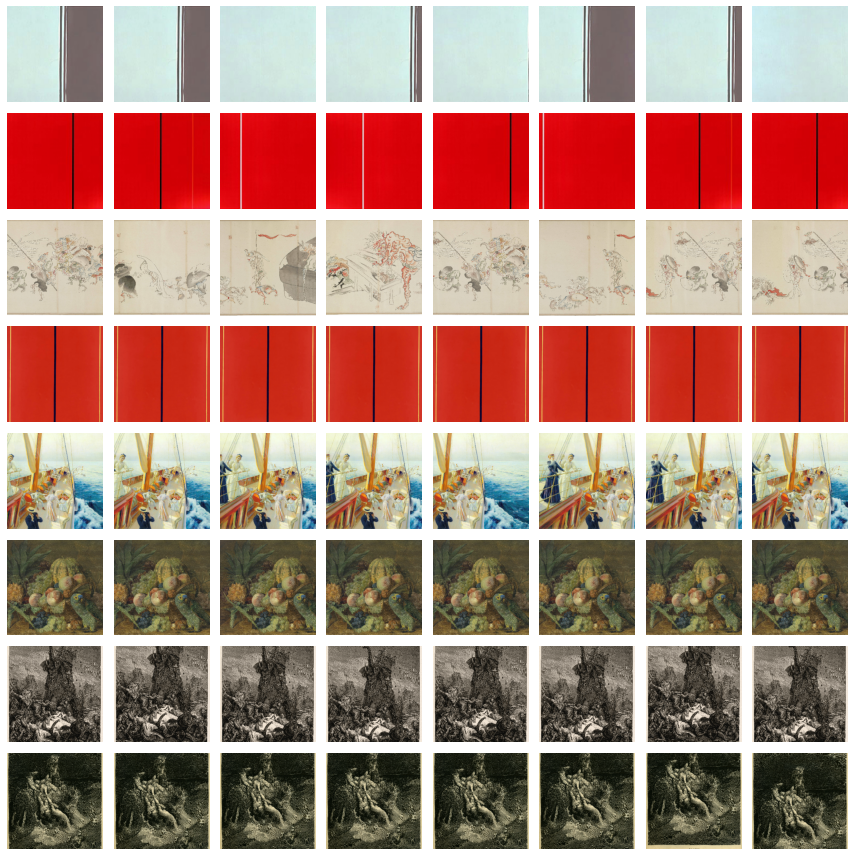

In [25]:
visualize(to_image(tf.concat([e[0][:8] for e in samples[:8]], axis=0)),
          rows=8,
          figsize=(12, 12))

In [26]:
del samples

## Network

In [27]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  classifier_activation=None,
  include_top=False,
  input_shape=Config.data.shape
)

Loading InceptionV3


In [28]:
backbone = tf.keras.Model(
  inputs=backbone.inputs,
  outputs=[backbone.get_layer(l).output for l in Config.model.feature_layers]
)

### Classification Head

In [29]:
from tensorflow_addons.layers import SpatialPyramidPooling2D
from tensorflow.keras.layers import Conv2D, Dropout, Dense, GlobalAveragePooling1D


def build_classifier(backbone, opts):
  opts = opt_or_default(opts)

  x = tf.keras.Input(Config.data.shape, name='images')
  
  activations = backbone(x)
  features = []

  for ix, (name, y) in enumerate(zip(Config.model.feature_layers, activations)):
    y = SpatialPyramidPooling2D(bins=[1, 3, 5], name=f'pyramid_features/{name}')(y)
    y = GlobalAveragePooling1D(name=f'avg/{name}')(y)
    features.append(y)
  
  y = tf.keras.layers.concatenate(features, name='concat')
  y = Dense(len(CLASSES), name='predictions', **opts('predictions'))(y)

  return tf.keras.Model(
    inputs=x,
    outputs=y,
    name=f'clf_{Config.model.backbone.__name__}_pbn')

In [30]:
nn = build_classifier(backbone, Config.model.build_options)

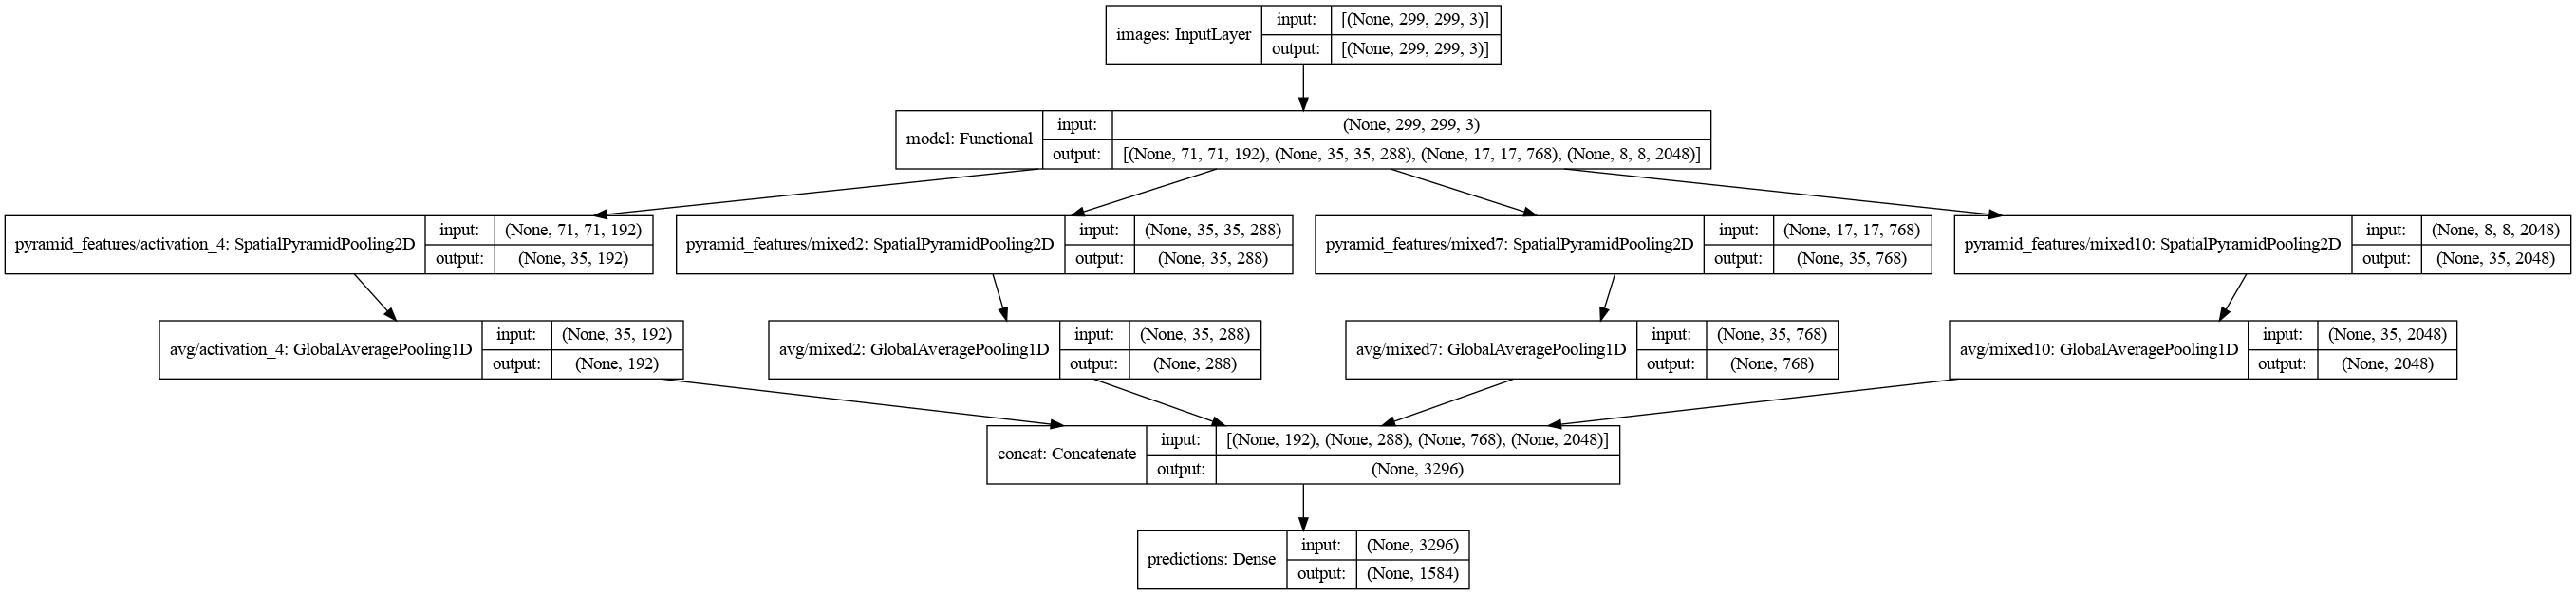

In [31]:
tf.keras.utils.plot_model(nn, show_shapes=True)

## Embedding

In [32]:
unfreeze_top_layers(
  backbone,
  Config.fine_tuning.unfreeze_layers,
  Config.fine_tuning.frozen_bn
)

nn.load_weights(Config.fine_tuning.weights)

Unfreezing 60% layers. Bottom-most is the 124-nth layer (batch_normalization_30).


In [33]:
nn.trainable = False

embed = tf.keras.Model(
  inputs=nn.inputs,
  outputs=nn.get_layer('concat').output,
  name='encoder'
)

In [34]:
@tf.function
def load_embed_fn(entry):
  entry = PainterByNumbers.decode_fn(entry)
  patches, targets = load_fn(entry)
  features = embed(patches, training=False)
  return features, targets

In [35]:
optimized_set = (
  tf.data.Dataset.range(SHARDS)
    .interleave(lambda i: dataset.shard(SHARDS, index=i),
                num_parallel_calls=tf.data.AUTOTUNE)
    .map(load_embed_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE))

In [39]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.numpy().tobytes()]))

def serialize_example(x, y):
  return (tf.train
            .Example(features=tf.train.Features(feature={
              'patches': _bytes_feature(x),
              'artist': _int64_feature(y[0]),
              'genre': _int64_feature(y[1]),
              'genre': _int64_feature(y[2]),
            }))
            .SerializeToString())

In [40]:
def serialized_generator():
  for sample in optimized_set:
    yield serialize_example(*sample)

serialized_features_dataset = tf.data.Dataset.from_generator(
    serialized_generator, output_types=tf.string, output_shapes=())

In [ ]:
filename = f'{data_dir}/embed.tfrecords'

writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

<ipython-input-39-5fa8441e290f>:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.numpy().tostring()]))
